In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import scipy.sparse as sp
import yaml
import time
import gget
import pickle
from scipy.spatial.distance import cdist
import scipy
from scipy.stats import zscore
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from adjustText import adjust_text

import anndata as an
import scanpy as sc
import scanpy.external as sce
import rapids_singlecell as rsc
import scvi

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import linregress, spearmanr
import matplotlib.patheffects as path_effects

import cupy as cp
from cuml.manifold import TSNE
from cuml.decomposition import PCA

sc.settings.verbosity = 3

# Load in data

In [2]:
%%time
fpath = "/scratch/indikar_root/indikar1/shared_data/HYB/endo_vs_exo/processed_all_groups_wExoEndo.h5ad"
adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()
adata

Memory usage: current 14.45 GB, difference +14.45 GB
CPU times: user 54.5 ms, sys: 6.36 s, total: 6.41 s
Wall time: 2min 33s


/nfs/turbo/umms-indikar/Jillian/conda-envs/rapids/lib/python3.13/site-packages/anndata/logging.py:57: FutureWarning: The specified parameters ('newline',) are no longer positional. Please specify them like `newline=False`
  print(format_memory_usage(get_memory_usage(), msg, newline))


AnnData object with n_obs × n_vars = 15950 × 25044
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'leiden_split'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'filter_pass', 'highly_variable', 'highly_variable_rank', 'm

In [3]:
## grab original adata to get other columns
path = "/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/anndata/processed_all_groups.h5ad"
bdata = sc.read_h5ad(path)
sc.logging.print_memory_usage()
bdata

Memory usage: current 16.33 GB, difference +1.88 GB


/nfs/turbo/umms-indikar/Jillian/conda-envs/rapids/lib/python3.13/site-packages/anndata/logging.py:57: FutureWarning: The specified parameters ('newline',) are no longer positional. Please specify them like `newline=False`
  print(format_memory_usage(get_memory_usage(), msg, newline))


AnnData object with n_obs × n_vars = 15950 × 25042
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'leiden_split'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'filter_pass', 'highly_variable', 'highly_variable_rank', 'm

In [4]:
adata.obsm['X_pca_harmony'] = bdata.obsm['X_pca_harmony'].copy()
adata.obsm['X_pca_original'] = bdata.obsm['X_pca_original'].copy()

adata.uns['leiden_split_colors'] = bdata.uns['leiden_split_colors'].copy()
adata.uns['phase_colors'] = bdata.uns['phase_colors'].copy()
adata.uns['pooled_condition_colors'] = bdata.uns['pooled_condition_colors'].copy()
adata.uns['dataset_colors'] = bdata.uns['dataset_colors'].copy()

adata

AnnData object with n_obs × n_vars = 15950 × 25044
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'leiden_split'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'filter_pass', 'highly_variable', 'highly_variable_rank', 'm

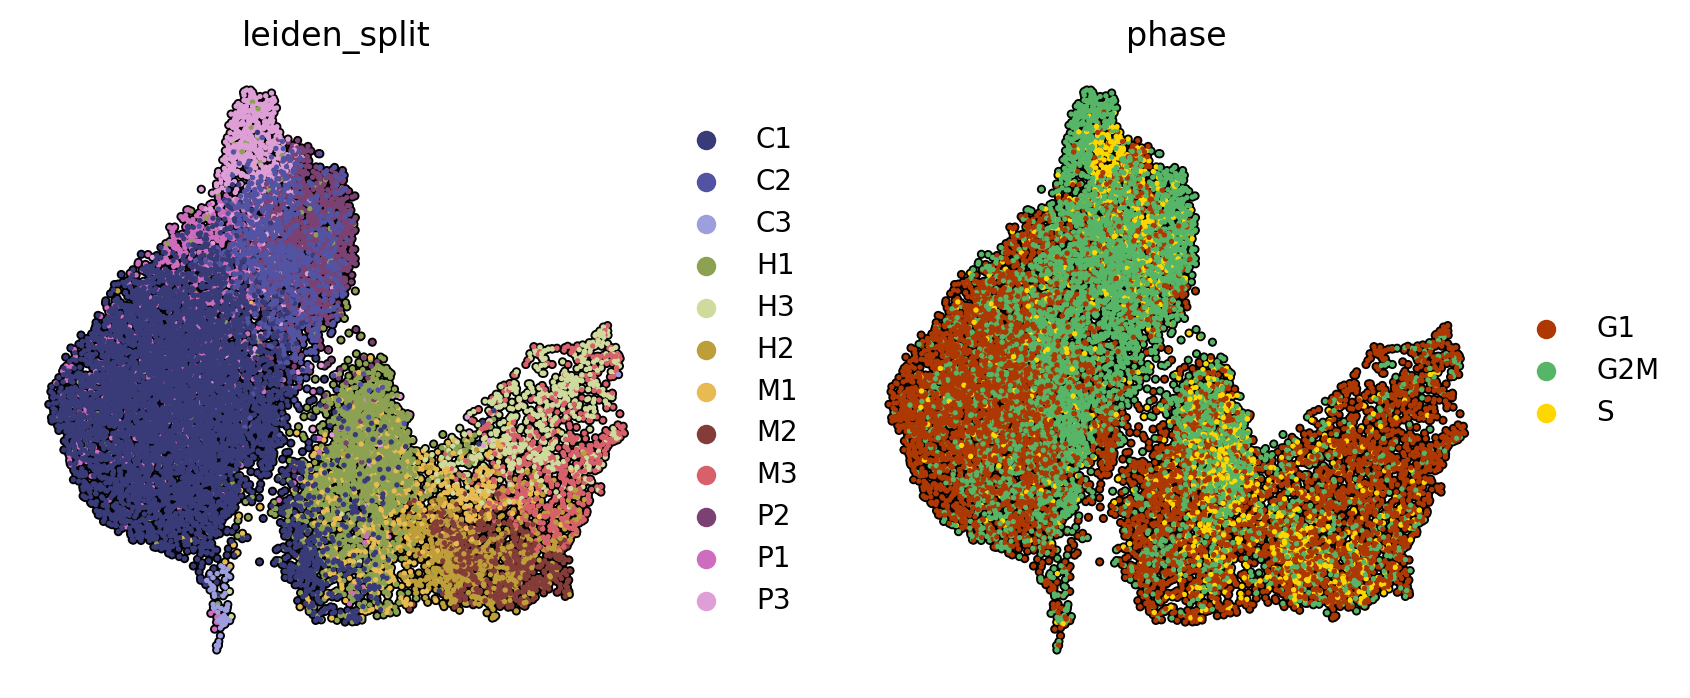

In [6]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.umap(
    adata,
    color=['leiden_split', 'phase'],
    size=15,
    ncols=2,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    alpha=1,
)

# Diffusion pseudotime

In [7]:
# def find_closest_cell(adata, obs_key='phase', value='G1', obsm_key='X_pca', dataset_key='dataset', dataset=None):
#     """
#     Find the cell closest to a median vector in PCA space for a given group and optional dataset.

#     Parameters:
#         adata (AnnData): Annotated data matrix.
#         obs_key (str): Key in adata.obs indicating group.
#         value (str): The value for aggregation (e.g., 'G1').
#         obsm_key (str): Key in adata.obsm for PCA or other embedding (e.g., 'X_pca').
#         dataset_key (str): Key in adata.obs for selecting grouping
#         dataset (str, optional): Name of dataset in adata.obs[dataset_key] to restrict search.

#     Returns:
#         tuple: (cell_id (str), index (int)) of the closest matching cell in adata.obs_names.
#     """
#     mask = adata.obs[obs_key] == value
#     if dataset is not None:
#         mask &= adata.obs[dataset_key] == dataset

#     emb = adata.obsm[obsm_key][mask]
    
#     if emb.shape[0] == 0:
#         raise ValueError("No cells match the specified filters.")

#     median_vec = np.median(emb, axis=0)
#     dists = cdist(emb, median_vec.reshape(1, -1)).flatten()
#     closest_idx = np.argmin(dists)

#     cell_id = adata.obs_names[mask][closest_idx]
#     cell_index = np.where(adata.obs_names == cell_id)[0][0]

#     return cell_id, cell_index

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9904525  0.96955025 0.9660328  0.9492391  0.937964
     0.9330071  0.92921424 0.92689    0.9259566  0.922896   0.92006993
     0.9052805  0.90172106 0.89445275]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
G1: root_id='ATGGTCATCAGTTACG_control' root_key=np.int64(10820)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)
G2M: root_id='CATCCAGGTAGGCCAG_control' root_key=np.int64(11401)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseu

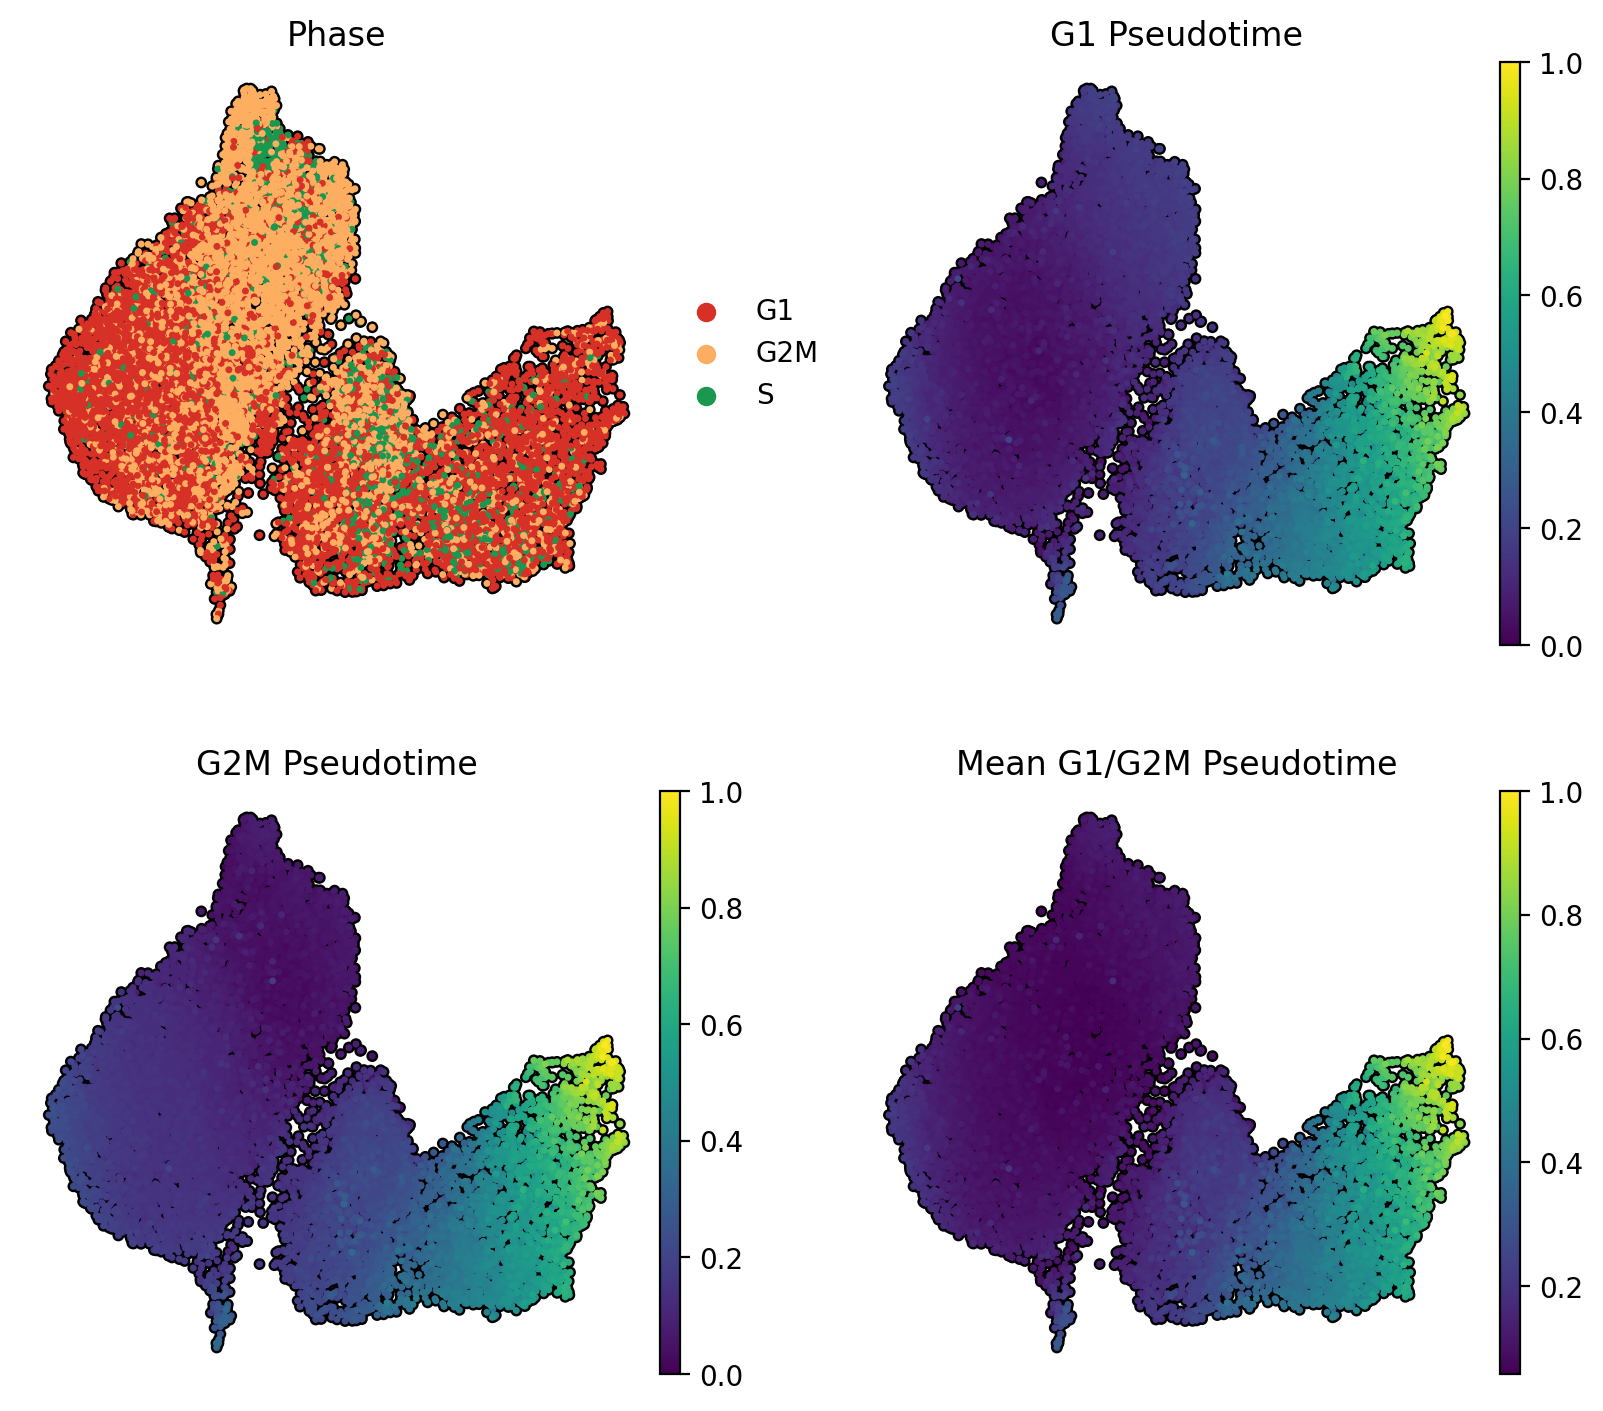

In [5]:
def find_closest_cell(adata, obs_key='barcoded_phase', value='G1', obsm_key='X_pca'):
    """
    Find the cell closest to a median vector in PCA space.

    Parameters:
        adata (AnnData): Annotated data matrix.
        obs_key (str): Key in adata.obs indicating group
        value (str): The value for aggregation 
        obsm_key (str): Key in adata.obsm for PCA or other embedding.

    Returns:
        tuple: (cell_id (str), index (int)) of the closest G1 cell in adata.obs_names
    """
    mask = adata.obs[obs_key] == value
    emb = adata.obsm[obsm_key][mask]

    median_vec = np.median(emb, axis=0)
    dists = cdist(emb, median_vec.reshape(1, -1)).flatten()
    closest_idx = np.argmin(dists)

    cell_id = adata.obs_names[mask][closest_idx]
    cell_index = np.where(adata.obs_names == cell_id)[0][0]

    return cell_id, cell_index



cdata = adata.copy()

sc.pp.neighbors(cdata, use_rep='X_pca_harmony')
sc.tl.diffmap(cdata)

# loop through initial state
for phase, cluster in zip(['G1', 'G2M'], ['C1', 'C2']):
    root_id, root_key = find_closest_cell(
        cdata,
        obs_key='leiden_split',
        value=cluster,
        obsm_key='X_pca_harmony',
    )

    print(f"{phase}: {root_id=} {root_key=}")

    cdata.uns["iroot"] = root_key
    sc.tl.dpt(cdata)
    cdata.obs[f'{phase}_pseudotime'] = cdata.obs['dpt_pseudotime']
    
    
cdata.obs['mean_pseudotime'] = cdata.obs[['G1_pseudotime', 'G2M_pseudotime']].mean(axis=1)   



plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

palette = {
    "G1": "#D73027",        # strong red (Cdt1+)
    "S": "#1A9850",         # green (Geminin+)
    "G2M": "#FDAE61",       # orange-yellow (Cdt1+/Geminin+)
    "unknown": "#B0B0B0", # Neutral gray
}

sc.pl.umap(
    cdata, 
    color=['phase', 'G1_pseudotime', 'G2M_pseudotime', 'mean_pseudotime'],
    size=25,
    ncols=2,
    alpha=1,
    use_raw=False,
    na_in_legend=False,
    add_outline=True,
    outline_color=('k', 'k'),
    palette=palette,
    title=['Phase', 'G1 Pseudotime', 'G2M Pseudotime', 'Mean G1/G2M Pseudotime'],
    frameon=False,
)

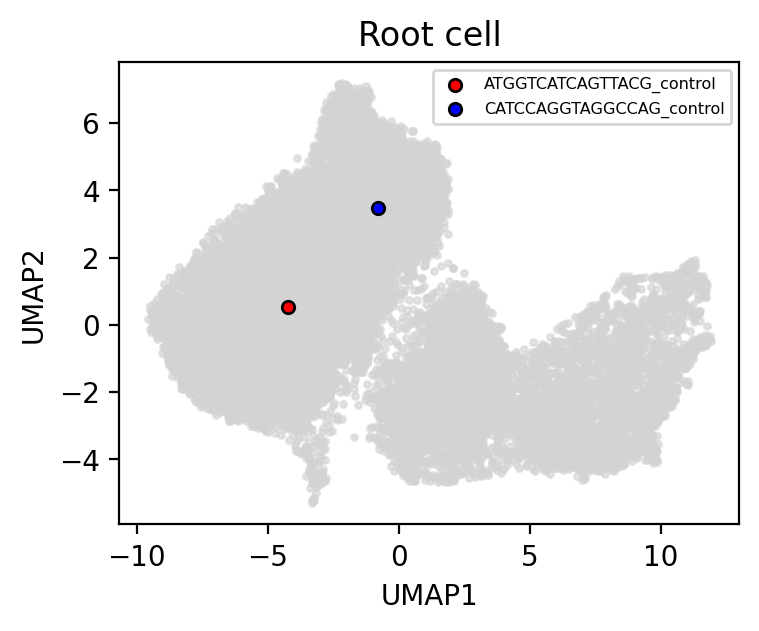

In [6]:
umap = cdata.obsm["X_umap"]
x, y = umap[:, 0], umap[:, 1]

# Plot all cells
plt.figure(figsize=(4, 3))
plt.scatter(x, y, s=5, color='lightgray', alpha=0.6)

# Highlight root cells
plt.scatter(x[10820], y[10820], s=20, color='red', edgecolor='black', label='ATGGTCATCAGTTACG_control')
plt.scatter(x[11401], y[11401], s=20, color='blue', edgecolor='black', label='CATCCAGGTAGGCCAG_control')

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(fontsize='xx-small')
plt.title("Root cell")
plt.show()

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9904525  0.96955025 0.9660328  0.9492391  0.937964
     0.9330071  0.92921424 0.92689    0.9259566  0.922896   0.92006993
     0.9052805  0.90172106 0.89445275]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
G1: cell_id='CCAGTATGTTTGGAAG_control' root_idx=np.int64(11569)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)
G2M: cell_id='TGCTACTTCGTGCTCC_control' root_idx=np.int64(15683)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseu

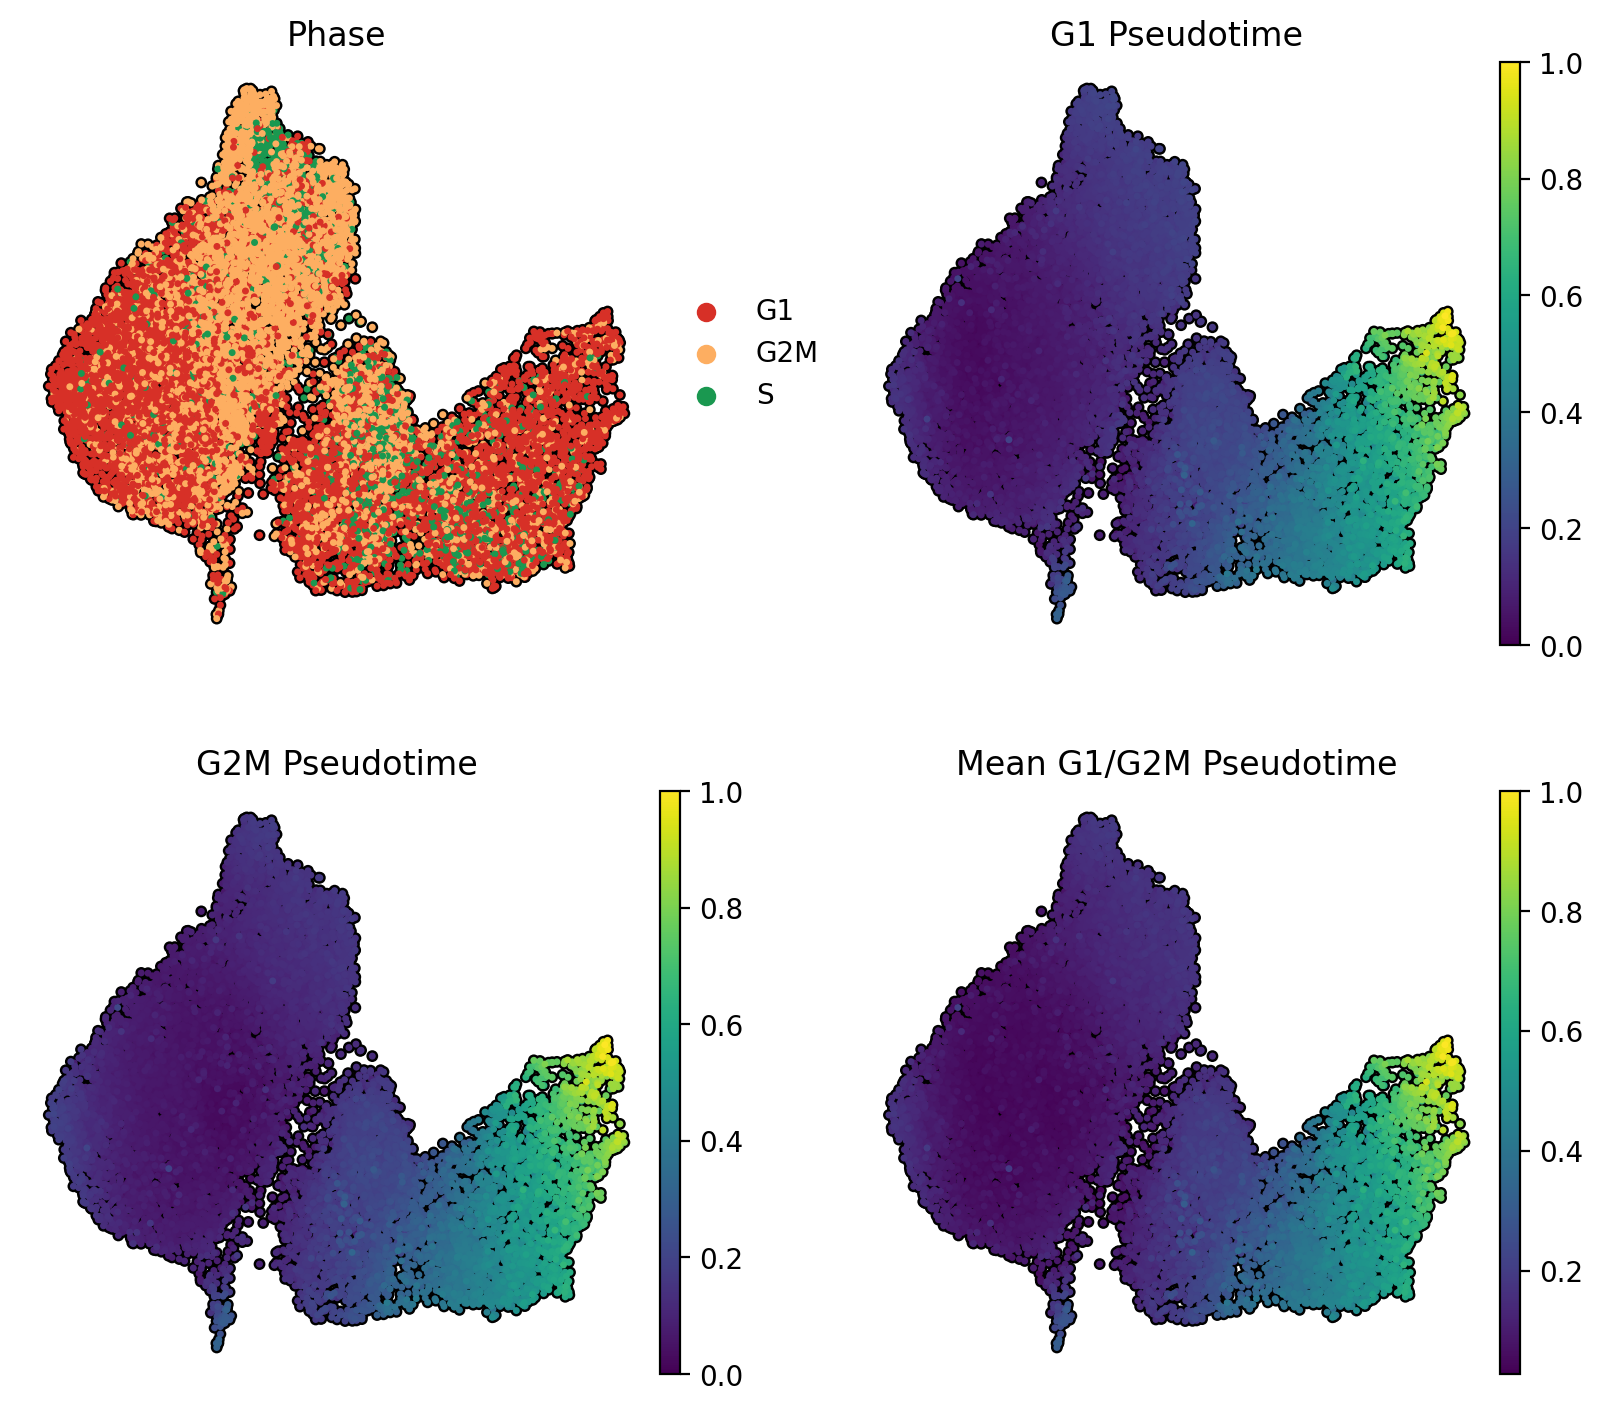

In [8]:
# cdata = adata.copy()

# sc.pp.neighbors(cdata, use_rep='X_pca_harmony')
# sc.tl.diffmap(cdata)

# for phase in ['G1', 'G2M']:

#     # choose representative cells from either G1 or G2M
#     cell_id, root_idx = find_closest_cell(
#         cdata, 
#         obs_key='phase', 
#         value=phase,
#         obsm_key='X_pca_harmony',
#         dataset_key='dataset',
#         dataset='Control',
#     )

#     print(f"{phase}: {cell_id=} {root_idx=}")

#     # set root and run pseudotime
#     cdata.uns["iroot"] = root_idx
#     sc.tl.dpt(cdata)#, n_branchings=2, allow_kendall_tau_shift=True)

#     cdata.obs[f'{phase}_pseudotime'] = cdata.obs['dpt_pseudotime']
#     # cdata.obs[f'{phase}_order'] = cdata.obs['dpt_order']
    
    
# cdata.obs['mean_pseudotime'] = cdata.obs[['G1_pseudotime', 'G2M_pseudotime']].mean(axis=1)
# # cdata.obs['mean_order'] = cdata.obs[['G1_order', 'G2M_order']].mean(axis=1)

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 4, 4

# palette = {
#     "G1": "#D73027",        # strong red (Cdt1+)
#     "S": "#1A9850",         # green (Geminin+)
#     "G2M": "#FDAE61",       # orange-yellow (Cdt1+/Geminin+)
#     "unknown": "#B0B0B0", # Neutral gray
# }

# sc.pl.umap(
#     cdata, 
#     color=['phase', 'G1_pseudotime', 'G2M_pseudotime', 'mean_pseudotime'],
#     size=25,
#     ncols=2,
#     alpha=1,
#     use_raw=False,
#     na_in_legend=False,
#     add_outline=True,
#     outline_color=('k', 'k'),
#     palette=palette,
#     title=['Phase', 'G1 Pseudotime', 'G2M Pseudotime', 'Mean G1/G2M Pseudotime'],
#     frameon=False,
# )

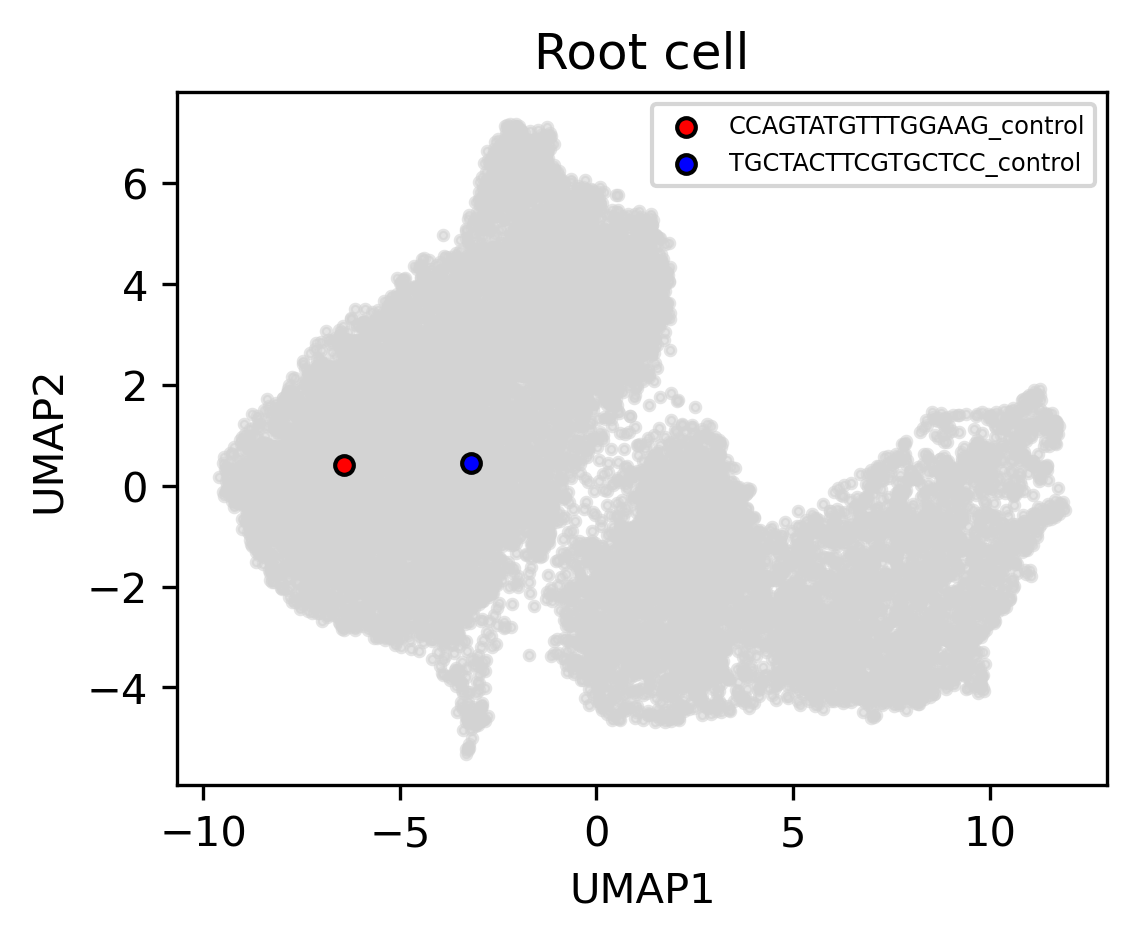

In [22]:
# umap = cdata.obsm["X_umap"]
# x, y = umap[:, 0], umap[:, 1]

# # Plot all cells
# plt.figure(figsize=(4, 3))
# plt.scatter(x, y, s=5, color='lightgray', alpha=0.6)

# # Highlight your cell
# plt.scatter(x[11569], y[11569], s=20, color='red', edgecolor='black', label='CCAGTATGTTTGGAAG_control')
# plt.scatter(x[15683], y[15683], s=20, color='blue', edgecolor='black', label='TGCTACTTCGTGCTCC_control')

# plt.xlabel("UMAP1")
# plt.ylabel("UMAP2")
# plt.legend(fontsize='xx-small')
# plt.title("Root cell")
# plt.show()

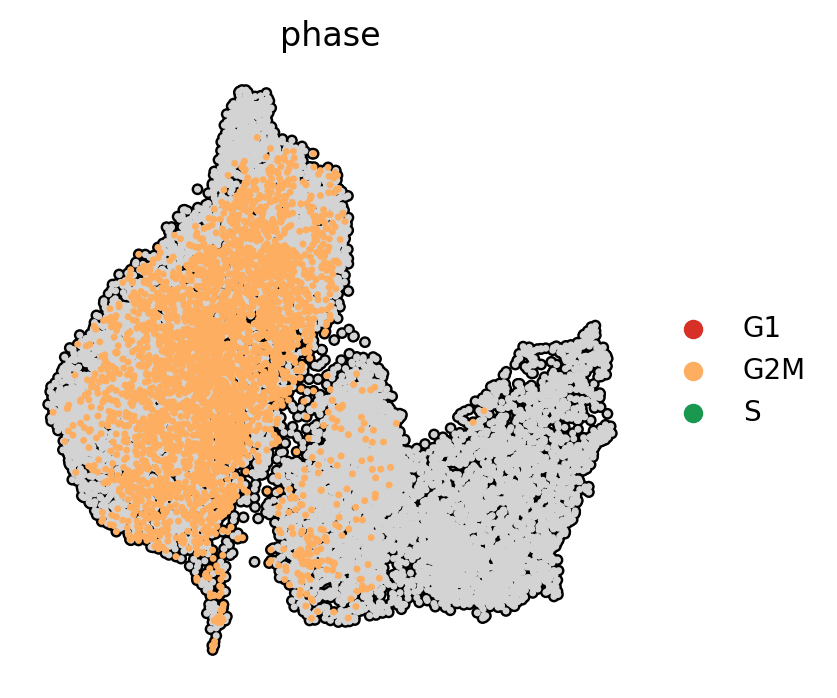

In [23]:
# mask_obs = (cdata.obs['pooled_condition'] == 'Control') & (cdata.obs['phase'] == 'G2M')

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 4, 4

# sc.pl.umap(
#     cdata,
#     color='phase',
#     mask_obs=mask_obs,
#     size=25,
#     ncols=1,
#     alpha=1,
#     use_raw=False,
#     na_in_legend=False,
#     add_outline=True,
#     outline_color=('k', 'k'),
#     frameon=False,
# )

# Load in velocity pseudotime orderings

In [7]:
path = "/scratch/indikar_root/indikar1/shared_data/HYB/scvelo/velocity_pseudotime_order.csv"

vdf = pd.read_csv(path)

vdf = vdf.set_index('Unnamed: 0')
vdf.index.name = None

print(vdf.shape)
vdf.head()

(15950, 3)


G1_velocity_pseudotime  G2M_velocity_pseudotime  \
AAACCAAAGCAACTGC_hybrid                0.154521                 0.145372   
AAACCAAAGTAGGGCA_hybrid                0.333950                 0.336306   
AAACCAAAGTCTAGGC_hybrid                0.171167                 0.182352   
AAACCATTCACGTAAT_hybrid                0.117458                 0.029513   
AAACCATTCAGGCAGA_hybrid                0.077805                 0.080426   

                         mean_velocity_pseudotime  
AAACCAAAGCAACTGC_hybrid                  0.149947  
AAACCAAAGTAGGGCA_hybrid                  0.335128  
AAACCAAAGTCTAGGC_hybrid                  0.176759  
AAACCATTCACGTAAT_hybrid                  0.073486  
AAACCATTCAGGCAGA_hybrid                  0.079115

In [8]:
# merge w adata
for col in vdf.columns:
    cdata.obs[col] = vdf.loc[cdata.obs.index, col]
    
cdata.obs.head()

MYOD-fb_counts  PRRX1-fb_counts  \
AAACCAAAGCAACTGC_hybrid             0.0              0.0   
AAACCAAAGTAGGGCA_hybrid            14.0              1.0   
AAACCAAAGTCTAGGC_hybrid             0.0              0.0   
AAACCATTCACGTAAT_hybrid             2.0             19.0   
AAACCATTCAGGCAGA_hybrid             0.0             22.0   

                         PRRX1_MYOD-fb_counts assigned_condition  \
AAACCAAAGCAACTGC_hybrid                  25.0         PRRX1_MYOD   
AAACCAAAGTAGGGCA_hybrid                   1.0               MYOD   
AAACCAAAGTCTAGGC_hybrid                  25.0         PRRX1_MYOD   
AAACCATTCACGTAAT_hybrid                   2.0              PRRX1   
AAACCATTCAGGCAGA_hybrid                   0.0              PRRX1   

                         total_fb_counts  condition_counts_rate  G1-fb_counts  \
AAACCAAAGCAACTGC_hybrid             25.0               1.000000           NaN   
AAACCAAAGTAGGGCA_hybrid             16.0               0.875000           NaN   
AAACCAAAGTCTAGGC_hybrid             25.0               1.000000           NaN   
AAACCATTCACGTAAT_hybrid             23.0               0.826087           NaN   
AAACCATTCAGGCAGA_hybrid             22.0               1.000000           NaN   

                         G2M-fb_counts  S-fb_counts dataset  ...  leiden  \
AAACCAAAGCAACTGC_hybrid            NaN          NaN  Hybrid  ...       0   
AAACCAAAGTAGGGCA_hybrid            NaN          NaN  Hybrid  ...       1   
AAACCAAAGTCTAGGC_hybrid            NaN          NaN  Hybrid  ...       0   
AAACCATTCACGTAAT_hybrid            NaN          NaN  Hybrid  ...       2   
AAACCATTCAGGCAGA_hybrid            NaN          NaN  Hybrid  ...       2   

                         cluster_str leiden_split  dpt_pseudotime  \
AAACCAAAGCAACTGC_hybrid           C1           H1        0.177655   
AAACCAAAGTAGGGCA_hybrid           C2           M1        0.400424   
AAACCAAAGTCTAGGC_hybrid           C1           H1        0.214939   
AAACCATTCACGTAAT_hybrid           C3           P2        0.045809   
AAACCATTCAGGCAGA_hybrid           C3           P2        0.056968   

                         G1_pseudotime  G2M_pseudotime  mean_pseudotime  \
AAACCAAAGCAACTGC_hybrid       0.180218        0.177655         0.178937   
AAACCAAAGTAGGGCA_hybrid       0.395529        0.400424         0.397976   
AAACCAAAGTCTAGGC_hybrid       0.203644        0.214939         0.209292   
AAACCATTCACGTAAT_hybrid       0.155166        0.045809         0.100488   
AAACCATTCAGGCAGA_hybrid       0.092814        0.056968         0.074891   

                         G1_velocity_pseudotime  G2M_velocity_pseudotime  \
AAACCAAAGCAACTGC_hybrid                0.154521                 0.145372   
AAACCAAAGTAGGGCA_hybrid                0.333950                 0.336306   
AAACCAAAGTCTAGGC_hybrid                0.171167                 0.182352   
AAACCATTCACGTAAT_hybrid                0.117458                 0.029513   
AAACCATTCAGGCAGA_hybrid                0.077805                 0.080426   

                         mean_velocity_pseudotime  
AAACCAAAGCAACTGC_hybrid                  0.149947  
AAACCAAAGTAGGGCA_hybrid                  0.335128  
AAACCAAAGTCTAGGC_hybrid                  0.176759  
AAACCATTCACGTAAT_hybrid                  0.073486  
AAACCATTCAGGCAGA_hybrid                  0.079115  

[5 rows x 42 columns]

Spearman ρ = 0.96, p = 0.00e+00


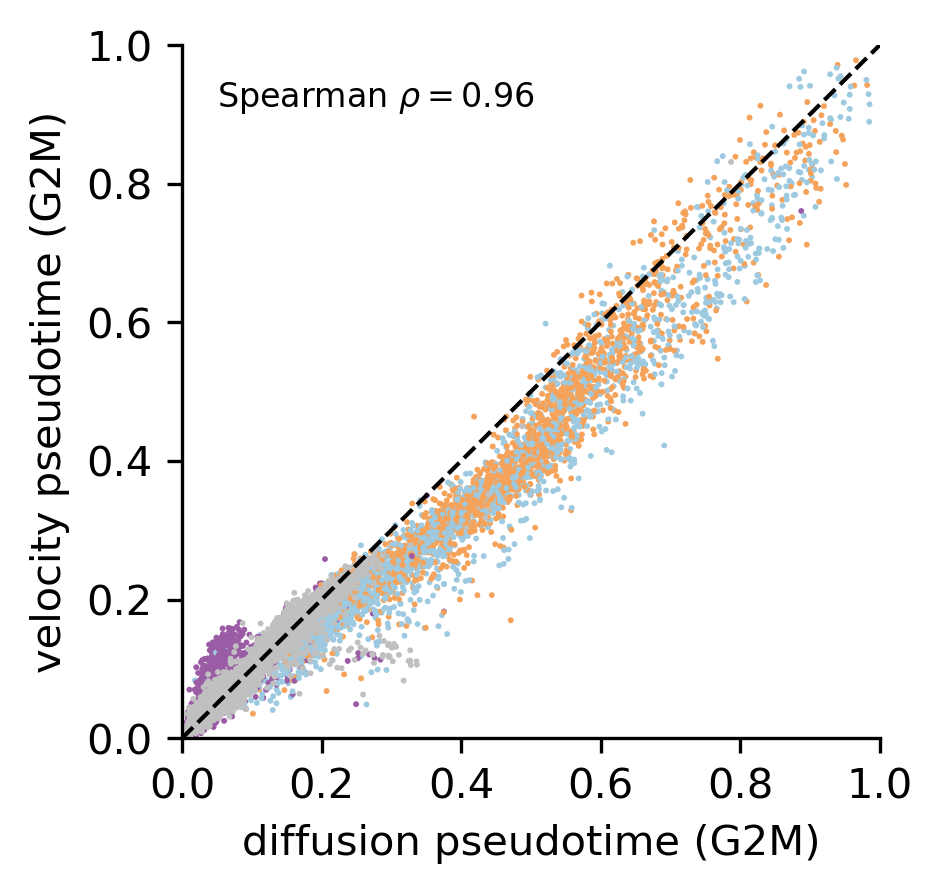

In [9]:
# dpt_col = 'mean_pseudotime'
# velo_col = 'mean_velocity_pseudotime'

# dpt_col = 'G1_pseudotime'
# velo_col = 'G1_velocity_pseudotime'

dpt_col = 'G2M_pseudotime'
velo_col = 'G2M_velocity_pseudotime'


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

palette = cdata.uns['pooled_condition_colors']

sns.scatterplot(
    data=cdata.obs,
    x=dpt_col,
    y=velo_col,
    hue='pooled_condition',
    palette=palette,
    edgecolor='none',
    s=2,
    legend=False,
    linewidth=0
)

from scipy.stats import spearmanr

rho, p = spearmanr(
    cdata.obs[dpt_col],
    cdata.obs[velo_col]
)

print(f"Spearman ρ = {rho:.2f}, p = {p:.2e}")


plt.text(
    0.05, 0.95,
    f"Spearman $\\rho = {rho:.2f}$",
    transform=plt.gca().transAxes,
    ha='left', va='top', fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.8)
)

# identity line
x = cdata.obs[dpt_col]
y = cdata.obs[velo_col]

lims = [
    min(x.min(), y.min()),
    max(x.max(), y.max())
]

plt.plot(lims, lims, '--', color='black', linewidth=1)
plt.xlim(lims)
plt.ylim(lims)

# Label axes
dpt_col_label = dpt_col.split("_")[0]
velo_col_label = velo_col.split("_")[0]

plt.xlabel(f"diffusion pseudotime ({dpt_col_label})")
plt.ylabel(f"velocity pseudotime ({velo_col_label})")

# Remove top and right spines for cleaner visualization
sns.despine()

In [26]:
cdata

AnnData object with n_obs × n_vars = 15950 × 25044
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'leiden_split', 'dpt_pseudotime', 'G1_pseudotime', 'G2M_pseudotime', 'mean_pseudotime', 'G1_velocity_pseudotime', 'G2M_velocity_pseudotime', 'mean_velocity_pseudotime'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'lo

# Endo Exo over pseudotime

Using layer=log_norm...


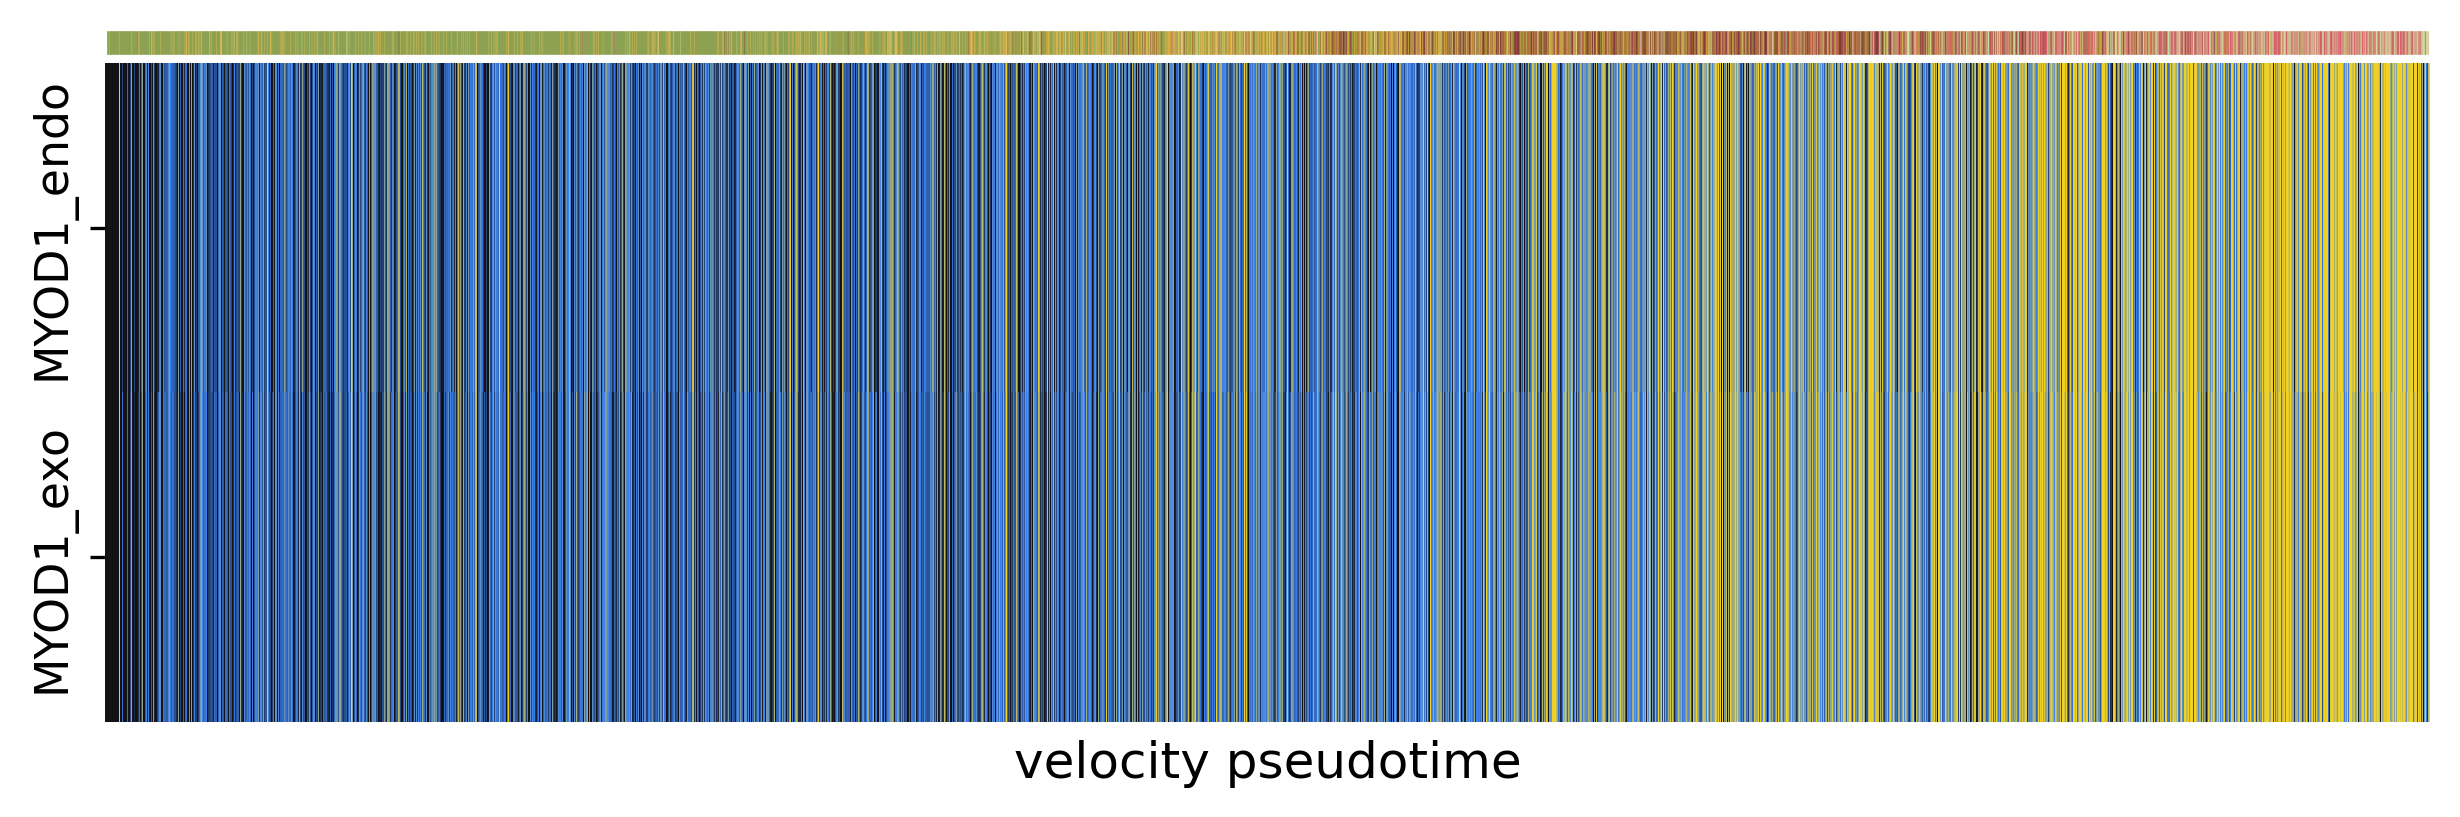

In [10]:
# plot endo vs exo over pseudotime

from matplotlib import gridspec
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap

low = '#131317' # dark
mid = '#3B80EB' # blue
high = '#F2D123' # yellow

custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap",
    [(0.0, low), (0.15, low), (0.5, mid), (0.85, high), (1.0, high)]
)

# cell_order = cdata.obs.sort_values("G2M_velocity_pseudotime").index
# n_cells = len(cell_order)


layer = 'log_norm'
print(f"Using layer={layer}...")
cdata.X = cdata.layers[layer].copy()


selected_genes = ['MYOD1_endo', 'MYOD1_exo']


# --- Filter cells for relevant conditions ---
condition_mask = cdata.obs['pooled_condition'].isin(['mmMYOD1', 'siPRRX1/mmMYOD1'])
cell_order = cdata.obs.loc[condition_mask].sort_values("G2M_velocity_pseudotime").index
n_cells = len(cell_order)



expr = cdata[cell_order, selected_genes].X
if not isinstance(expr, np.ndarray):
    expr = expr.toarray()

# z-score expression
expr_z = zscore(expr, axis=0)

# get bar for cluster order
clusters = cdata.obs.loc[cell_order, 'leiden_split']

# mapping: category → color
cluster_colors = dict(zip(
    cdata.obs['leiden_split'].cat.categories,
    cdata.uns['leiden_split_colors']
))

# convert cluster labels to colors for each cell in order
col_colors = clusters.map(cluster_colors).to_numpy()
rgba_colors = np.array([to_rgba(c) for c in col_colors])


fig = plt.figure(figsize=(10,3), dpi=300)

gs = gridspec.GridSpec(
    2, 1, 
    height_ratios=[0.4, 10],   # small top bar, big heatmap
    hspace=0.02                 # small spacing
)

# --- Top colorbar axis (tiny horizontal strip) ---
ax_color = fig.add_subplot(gs[0])

ax_color.imshow(rgba_colors[np.newaxis, :, :], aspect='auto')
ax_color.set_xlim(0, n_cells)
ax_color.set_xticks([])
ax_color.set_yticks([])
for spine in ax_color.spines.values():
    spine.set_edgecolor('white')

ax_heat = fig.add_subplot(gs[1])

sns.heatmap(
    expr_z.T,
    cmap=custom_cmap,
    xticklabels=False,
    yticklabels=selected_genes,
    vmin=-2,
    vmax=2,
    cbar=False,
    ax=ax_heat,
)
ax_heat.set_yticklabels(ax_heat.get_yticklabels(), fontsize=11)
ax_heat.set_xlabel("velocity pseudotime", fontsize=12)
ax_heat.set_ylabel("")

plt.tight_layout()
plt.show()

In [31]:
# which cells have high ratio? where is there position in pseudotime?

cdata

AnnData object with n_obs × n_vars = 15950 × 25044
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'leiden_split', 'dpt_pseudotime', 'G1_pseudotime', 'G2M_pseudotime', 'mean_pseudotime', 'G1_velocity_pseudotime', 'G2M_velocity_pseudotime', 'mean_velocity_pseudotime'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'lo

# High ratio endo/exo

In [11]:
# compute ratio of exo and endo
endo_idx = cdata.var_names.get_loc('MYOD1_endo')
exo_idx  = cdata.var_names.get_loc('MYOD1_exo')

layer = 'norm'

expr = cdata.layers[layer]
if not isinstance(expr, np.ndarray):
    expr = expr.toarray()

endo_exp = expr[:, endo_idx]
exo_exp  = expr[:, exo_idx]

# Calculate ratio safely (NaN where exo is 0)
ratio = np.divide(endo_exp, exo_exp, out=np.full_like(endo_exp, np.nan), where=exo_exp!=0)

cdata.obs['MYOD1_endo_exo_ratio'] = ratio

# display(adata_expanded.obs.head())
display(cdata.obs['MYOD1_endo_exo_ratio'].describe())

count    5993.000000
mean        0.565769
std         0.190281
min         0.000000
25%         0.481481
50%         0.566667
75%         0.660714
max         1.000000
Name: MYOD1_endo_exo_ratio, dtype: float64

In [12]:
df = cdata.obs[['pooled_condition', 'leiden_split', 'MYOD1_endo_exo_ratio', 'G2M_velocity_pseudotime']].copy()

df['pooled_condition'] = df['pooled_condition'].astype(str)
# df['leiden_split'] = df['leiden_split'].astype(str)

df = df.dropna(subset='MYOD1_endo_exo_ratio')


# compute percentiles
q = 0.75

percentiles = df.groupby('pooled_condition')['MYOD1_endo_exo_ratio'].quantile(q)

df['quant_t'] = df['pooled_condition'].map(percentiles)

# filter based on quantile per condition
df = df[df['MYOD1_endo_exo_ratio'] >= df['quant_t']]
print(df.shape)


tmp = df[df['pooled_condition'].isin(['mmMYOD1', 'siPRRX1/mmMYOD1'])].copy()

print(tmp.shape)
tmp.head()

(1639, 5)
(1380, 5)


pooled_condition leiden_split  MYOD1_endo_exo_ratio  \
AAACCAAAGTCTAGGC_hybrid  siPRRX1/mmMYOD1           H1              0.685714   
AAACCCGCACCATAGG_hybrid          mmMYOD1           M1              0.689655   
AAACCCTGTAACGACA_hybrid          mmMYOD1           M1              0.739130   
AAACGAATCCCGCTTA_hybrid  siPRRX1/mmMYOD1           H1              1.000000   
AAACGGGTCCTGATAG_hybrid  siPRRX1/mmMYOD1           H1              1.000000   

                         G2M_velocity_pseudotime   quant_t  
AAACCAAAGTCTAGGC_hybrid                 0.182352  0.666667  
AAACCCGCACCATAGG_hybrid                 0.249138  0.613333  
AAACCCTGTAACGACA_hybrid                 0.210607  0.613333  
AAACGAATCCCGCTTA_hybrid                 0.180353  0.666667  
AAACGGGTCCTGATAG_hybrid                 0.192329  0.666667

In [13]:
tmp['pooled_condition'].value_counts()

pooled_condition
siPRRX1/mmMYOD1    851
mmMYOD1            529
Name: count, dtype: int64

In [51]:
# df.groupby('pooled_condition')['MYOD1_endo_exo_ratio'].describe()

count      mean       std  min       25%       50%  \
pooled_condition                                                        
mmMYOD1           2109.0  0.543844  0.107611  0.0  0.477273  0.545455   
siPRRX1            527.0  0.575562  0.452514  0.0  0.000000  0.666667   
siPRRX1/mmMYOD1   3357.0  0.578006  0.157513  0.0  0.500000  0.583333   

                       75%  max  
pooled_condition                 
mmMYOD1           0.613333  1.0  
siPRRX1           1.000000  1.0  
siPRRX1/mmMYOD1   0.666667  1.0

In [52]:
# t = 0.75

# df['high_ratio'] = df['MYOD1_endo_exo_ratio'] >= t

# df.head()

pooled_condition leiden_split  MYOD1_endo_exo_ratio  \
AAACCAAAGCAACTGC_hybrid  siPRRX1/mmMYOD1           H1              0.537634   
AAACCAAAGTAGGGCA_hybrid          mmMYOD1           M1              0.511628   
AAACCAAAGTCTAGGC_hybrid  siPRRX1/mmMYOD1           H1              0.685714   
AAACCATTCCGTAATG_hybrid  siPRRX1/mmMYOD1           H2              0.578947   
AAACCCGCACCATAGG_hybrid          mmMYOD1           M1              0.689655   

                         G2M_velocity_pseudotime  high_ratio  
AAACCAAAGCAACTGC_hybrid                 0.145372       False  
AAACCAAAGTAGGGCA_hybrid                 0.336306       False  
AAACCAAAGTCTAGGC_hybrid                 0.182352       False  
AAACCATTCCGTAATG_hybrid                 0.281764       False  
AAACCCGCACCATAGG_hybrid                 0.249138       False

In [53]:
# df['high_ratio'].value_counts()

high_ratio
False    5301
True      692
Name: count, dtype: int64

In [54]:
# tmp = df[df['high_ratio']].copy()

# tmp = tmp[tmp['pooled_condition'].isin(['mmMYOD1', 'siPRRX1/mmMYOD1'])]

# print(tmp.shape)
# tmp.head()

(430, 5)


pooled_condition leiden_split  MYOD1_endo_exo_ratio  \
AAACGAATCCCGCTTA_hybrid  siPRRX1/mmMYOD1           H1              1.000000   
AAACGGGTCCTGATAG_hybrid  siPRRX1/mmMYOD1           H1              1.000000   
AAAGCTGGTTCGGTTG_hybrid          mmMYOD1           M1              0.756757   
AAAGTGATCAGGTTGC_hybrid  siPRRX1/mmMYOD1           H2              0.800000   
AACAGTAAGTCGATTG_hybrid  siPRRX1/mmMYOD1           H1              0.787879   

                         G2M_velocity_pseudotime  high_ratio  
AAACGAATCCCGCTTA_hybrid                 0.180353        True  
AAACGGGTCCTGATAG_hybrid                 0.192329        True  
AAAGCTGGTTCGGTTG_hybrid                 0.228142        True  
AAAGTGATCAGGTTGC_hybrid                 0.247209        True  
AACAGTAAGTCGATTG_hybrid                 0.189620        True

## Over pseudotime

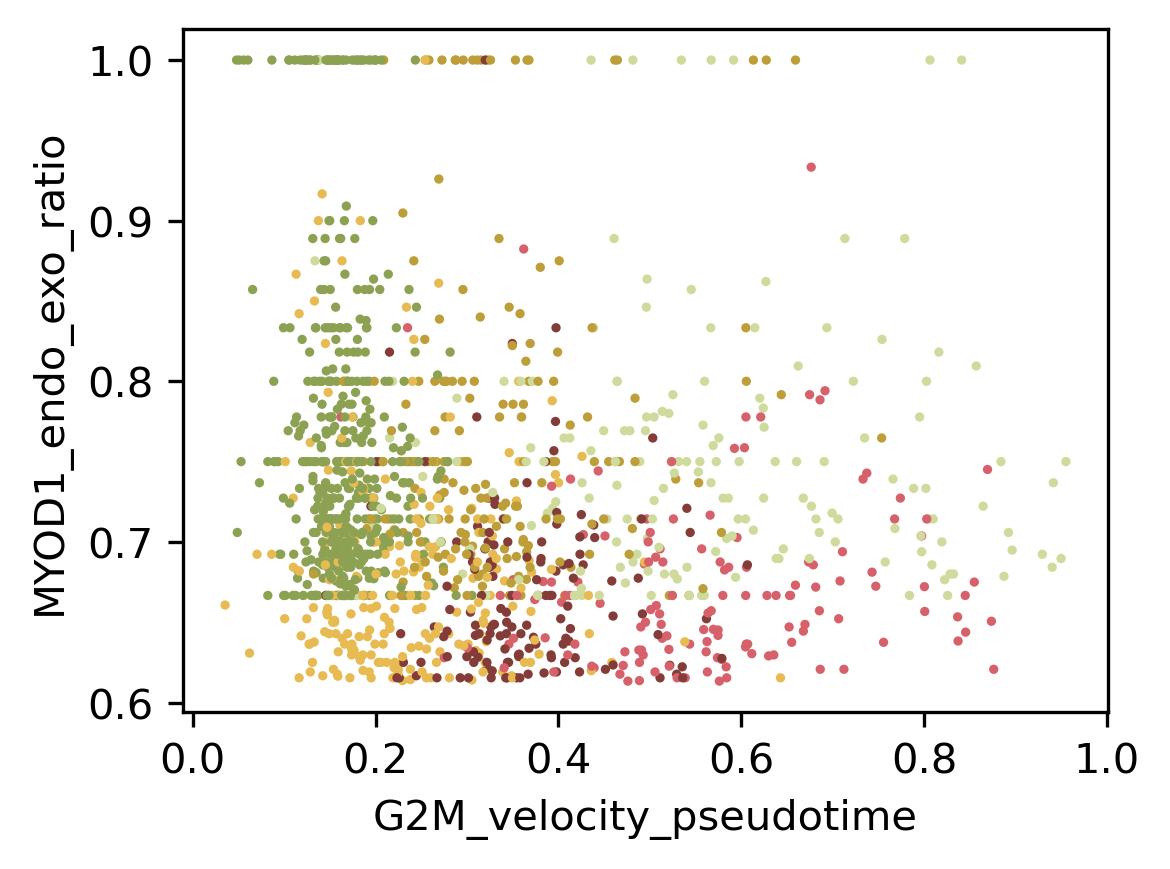

In [14]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 3

sns.scatterplot(
    data=tmp,
    x='G2M_velocity_pseudotime',
    y='MYOD1_endo_exo_ratio',
    hue='leiden_split',
    palette=cdata.uns['leiden_split_colors'],
    edgecolor='none',
    s=5,
    legend=False,
    linewidth=0,
)

plt.tight_layout()
plt.show()

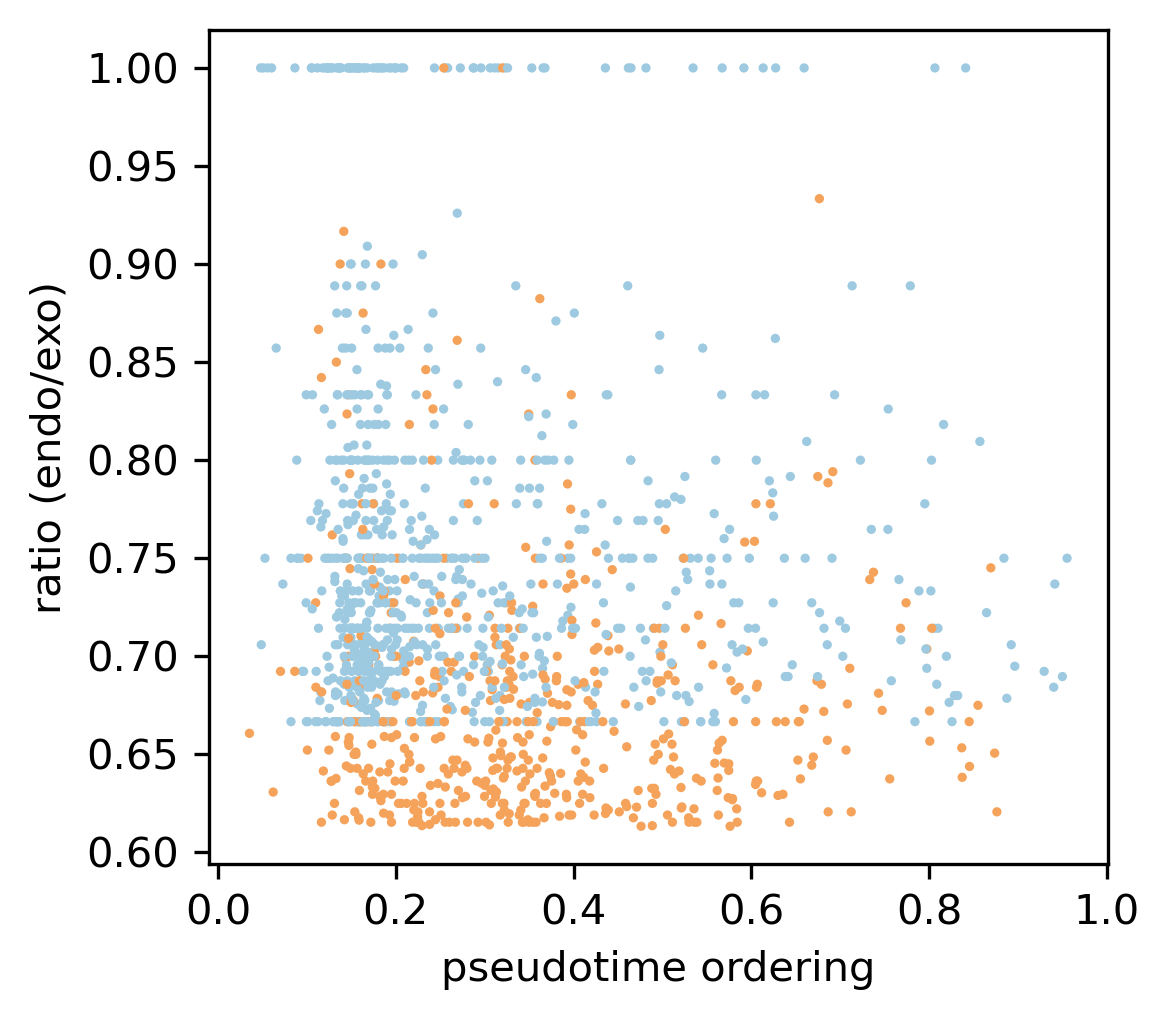

In [21]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 3.5

sns.scatterplot(
    data=tmp,
    x='G2M_velocity_pseudotime',
    y='MYOD1_endo_exo_ratio',
    hue='pooled_condition',
    palette=['#9ECAE1', '#F5A35B'],
    edgecolor='none',
    s=5,
    legend=False,
    linewidth=0,
)

plt.ylabel("ratio (endo/exo)")
plt.xlabel("pseudotime ordering")


plt.tight_layout()
plt.show()

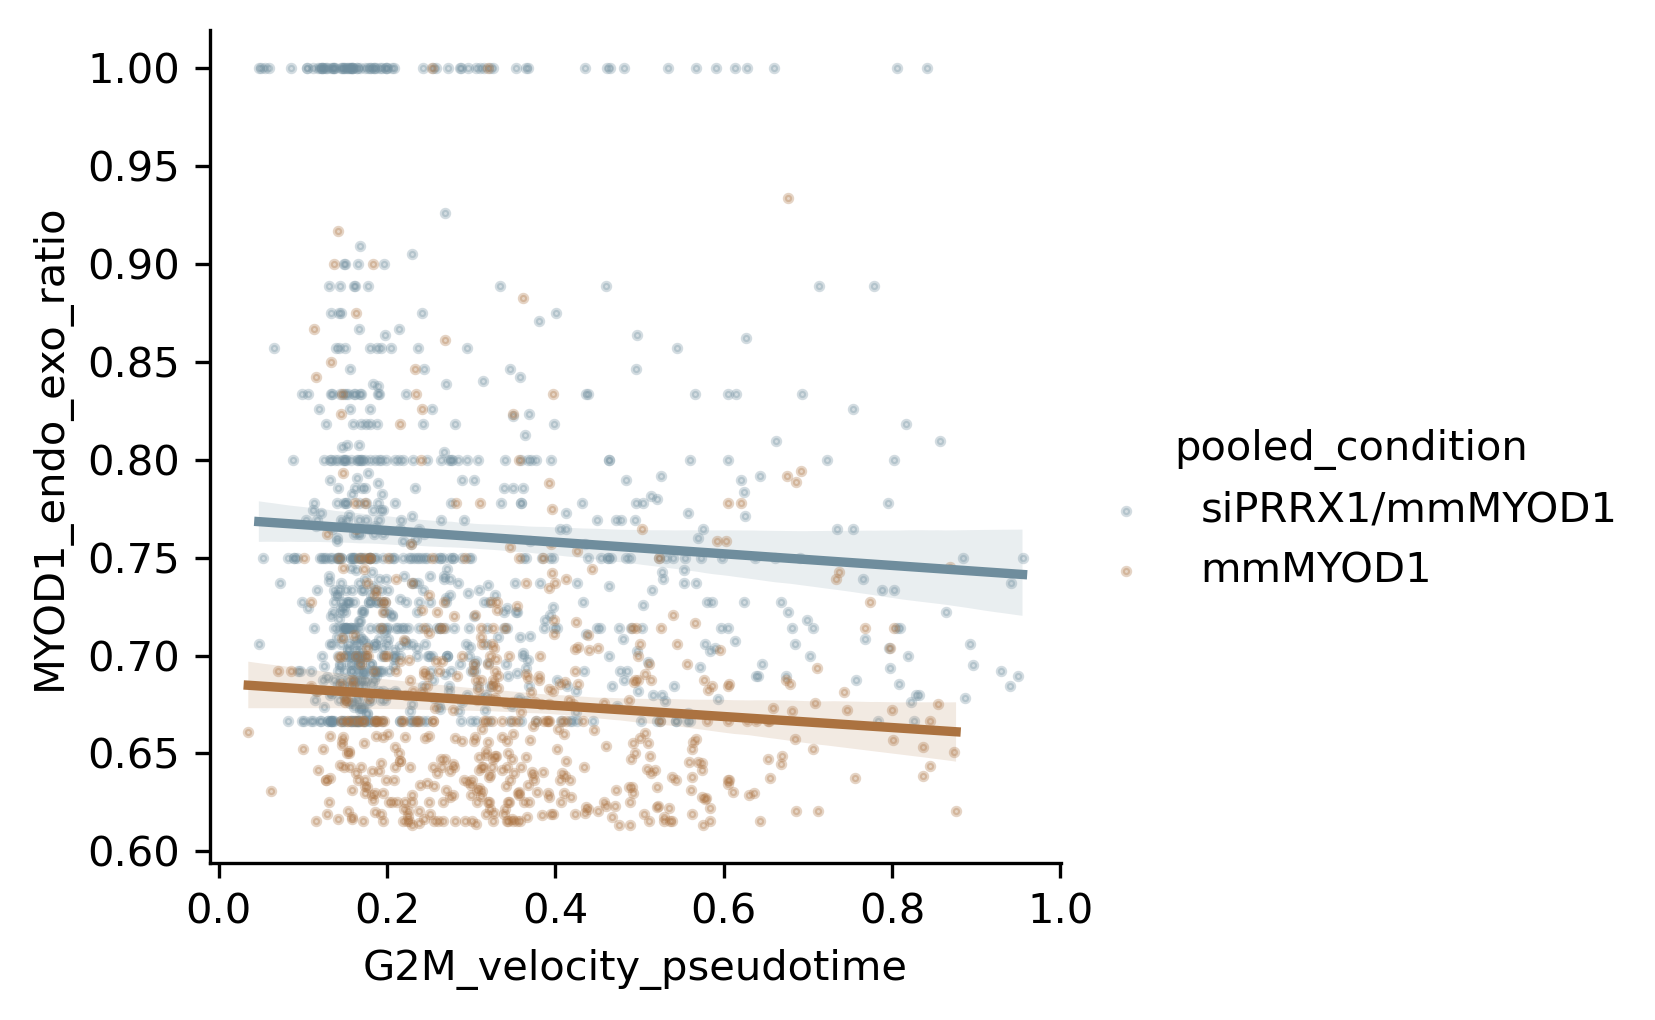

In [39]:
light_palette = ['#9ECAE1', '#F5A35B']
# Generate darker shades (multiply RGB by a factor)
def darken(hex_color, factor=0.7):
    rgb = np.array(to_rgb(hex_color))
    return tuple((rgb * factor).clip(0, 1))
dark_palette = [darken(c) for c in light_palette]

sns.lmplot(
    data=tmp,
    x='G2M_velocity_pseudotime',
    y='MYOD1_endo_exo_ratio',
    hue='pooled_condition',
    palette=dark_palette,
    height=3.5,
    aspect=4/3.5,
    scatter=True,
    # size=5,
    scatter_kws={'s': 3, 'alpha': 0.3},
    # alpha=1,
)

plt.show()

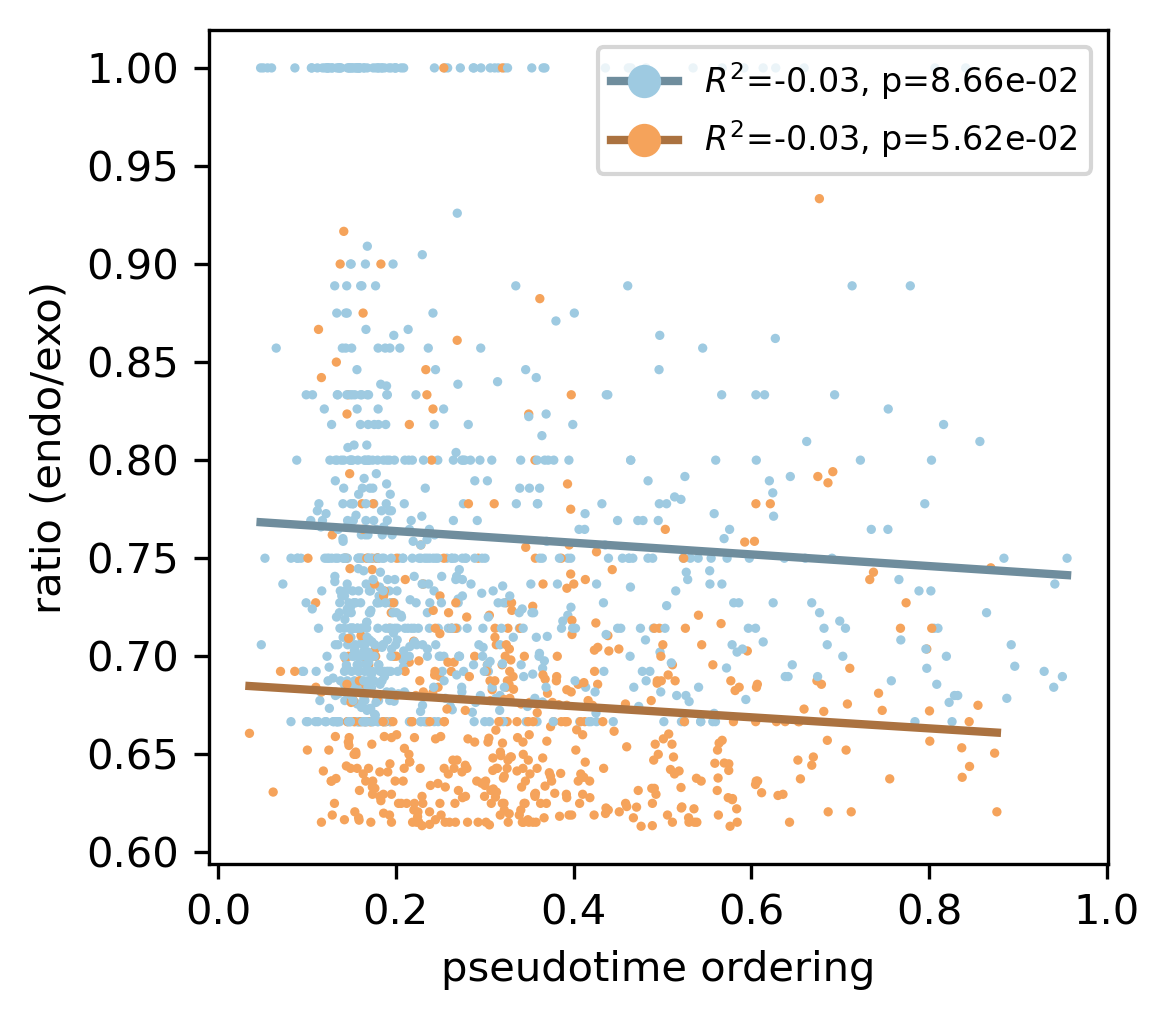

In [29]:
import statsmodels.api as sm
from matplotlib.colors import to_rgb

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 3.5

light_palette = ['#9ECAE1', '#F5A35B']
group_list = tmp['pooled_condition'].unique()

# Generate darker shades (multiply RGB by a factor)
def darken(hex_color, factor=0.7):
    rgb = np.array(to_rgb(hex_color))
    return tuple((rgb * factor).clip(0, 1))

dark_palette = [darken(c) for c in light_palette]



# Scatter plot
sns.scatterplot(
    data=tmp,
    x='G2M_velocity_pseudotime',
    y='MYOD1_endo_exo_ratio',
    hue='pooled_condition',
    palette=light_palette,
    edgecolor='none',
    s=5,
    legend=False,  # We'll make our own legend
    linewidth=0,
)

legend_labels = []

for group, light, dark in zip(group_list, light_palette, dark_palette):
    group_data = tmp[tmp['pooled_condition'] == group]
    X = group_data['G2M_velocity_pseudotime'].values
    y = group_data['MYOD1_endo_exo_ratio'].values

    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm).fit()

    slope = model.params[1]
    pval = model.pvalues[1]

    # Plot regression line -- darker color
    xs = np.linspace(X.min(), X.max(), 100)
    ys = model.params[0] + model.params[1]*xs
    plt.plot(xs, ys, color=dark, lw=2)

    # Prepare legend label with stats
    legend_labels.append(
        f"$R^2$={slope:.2f}, p={pval:.2e}"
    )

# Custom legend handles
from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], marker='o', label=label,
           markerfacecolor=light_palette[idx], markeredgecolor='none', markersize=8,
           linestyle='-', linewidth=2, color=dark_palette[idx])
    for idx, label in enumerate(legend_labels)
]

plt.ylabel("ratio (endo/exo)")
plt.xlabel("pseudotime ordering")
plt.tight_layout()

# Add custom legend
plt.legend(handles=handles, loc='best', fontsize=8, frameon=True)

plt.show()


# Scatter plot
# sns.scatterplot(
#     data=tmp,
#     x='G2M_velocity_pseudotime',
#     y='MYOD1_endo_exo_ratio',
#     hue='pooled_condition',
#     palette=['#9ECAE1', '#F5A35B'],
#     edgecolor='none',
#     s=5,
#     legend=False,
#     linewidth=0,
# )

# for group, color in zip(tmp['pooled_condition'].unique(), ['#9ECAE1', '#F5A35B']):
#     group_data = tmp[tmp['pooled_condition'] == group]
#     X = group_data['G2M_velocity_pseudotime'].values
#     y = group_data['MYOD1_endo_exo_ratio'].values

#     # Add a constant for intercept in statsmodels
#     X_sm = sm.add_constant(X)
#     model = sm.OLS(y, X_sm).fit()

#     # Get slope (coefficient) and p-value
#     slope = model.params[1]  # This is the coefficient for x
#     pval = model.pvalues[1]  # This is the p-value for x

#     # Plot regression line
#     xs = np.linspace(X.min(), X.max(), 100)
#     ys = model.params[0] + model.params[1]*xs
#     plt.plot(xs, ys, color=color, lw=2, label=f'{group} fit')

#     # Annotate coefficient (slope) and p-value
#     plt.text(
#         xs.min(),
#         ys.min(),
#         f"$R^2$ ={slope:.2f}\np={pval:.2e}",
#         color=color,
#         fontsize=8,
#         verticalalignment='bottom'
#     )

# plt.ylabel("ratio (endo/exo)")
# plt.xlabel("pseudotime ordering")
# plt.tight_layout()
# plt.show()

In [35]:
dark_palette

[(np.float64(0.4337254901960784),
  np.float64(0.5545098039215686),
  np.float64(0.6176470588235293)),
 (np.float64(0.6725490196078431),
  np.float64(0.4474509803921568),
  np.float64(0.24980392156862744))]

In [70]:
tmp['leiden_split'].value_counts()

leiden_split
H1    491
M1    249
H2    183
H3    177
M3    141
M2    139
C1      0
C2      0
C3      0
P2      0
P1      0
P3      0
Name: count, dtype: int64

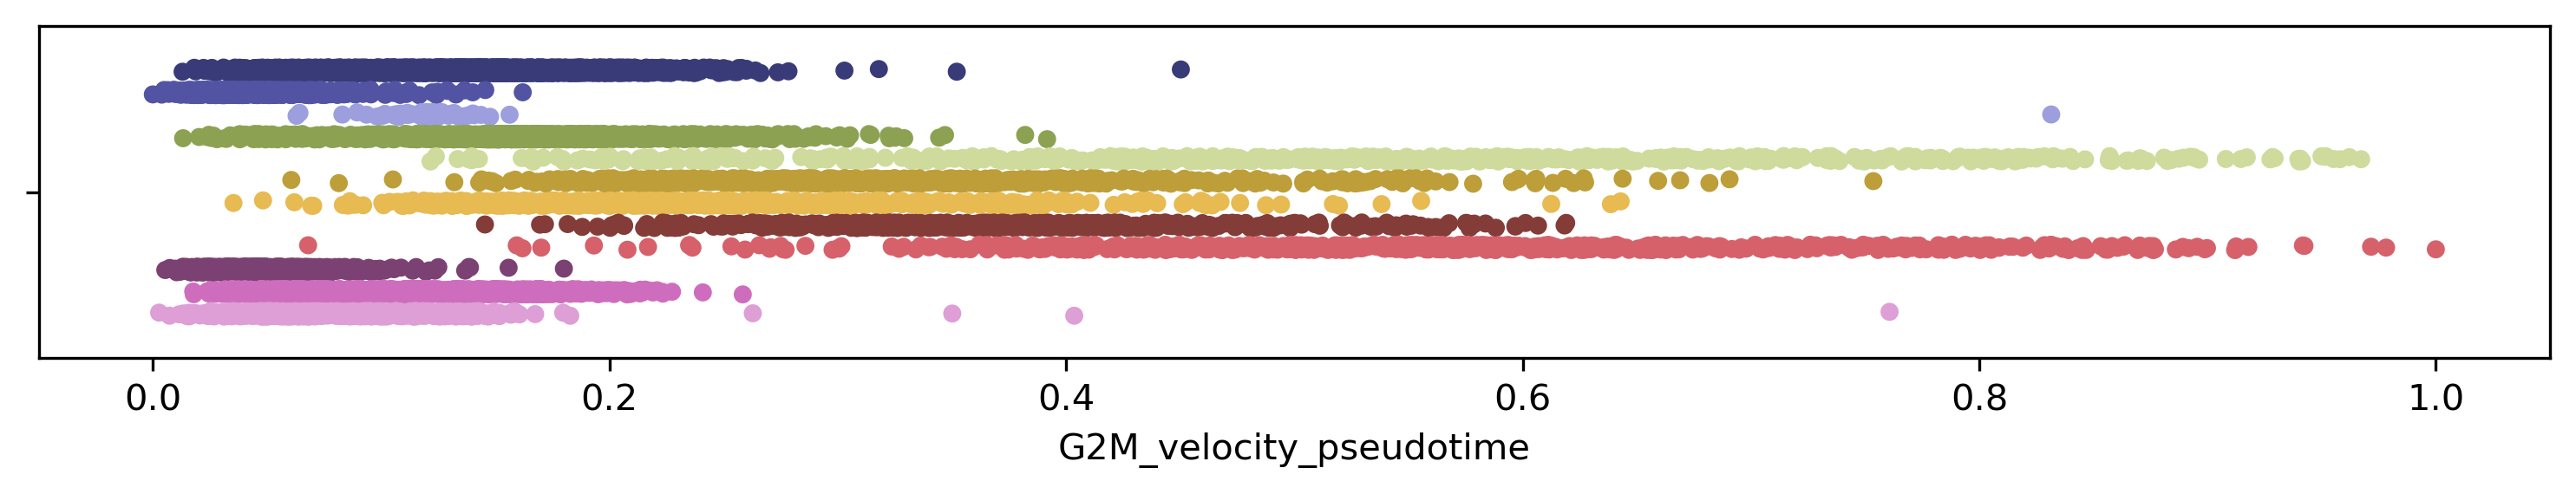

In [72]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 2

sns.stripplot(
    data=cdata.obs,
    x='G2M_velocity_pseudotime',
    hue='leiden_split',
    palette=cdata.uns['leiden_split_colors'],
    dodge=True,
    edgecolor='none',
    s=5,
    legend=False,
    linewidth=0,
)

plt.tight_layout()
plt.show()

In [73]:
tmp.head()

pooled_condition leiden_split  MYOD1_endo_exo_ratio  \
AAACCAAAGTCTAGGC_hybrid  siPRRX1/mmMYOD1           H1              0.685714   
AAACCCGCACCATAGG_hybrid          mmMYOD1           M1              0.689655   
AAACCCTGTAACGACA_hybrid          mmMYOD1           M1              0.739130   
AAACGAATCCCGCTTA_hybrid  siPRRX1/mmMYOD1           H1              1.000000   
AAACGGGTCCTGATAG_hybrid  siPRRX1/mmMYOD1           H1              1.000000   

                         G2M_velocity_pseudotime   quant_t  
AAACCAAAGTCTAGGC_hybrid                 0.182352  0.666667  
AAACCCGCACCATAGG_hybrid                 0.249138  0.613333  
AAACCCTGTAACGACA_hybrid                 0.210607  0.613333  
AAACGAATCCCGCTTA_hybrid                 0.180353  0.666667  
AAACGGGTCCTGATAG_hybrid                 0.192329  0.666667

In [75]:
high_ratio_cells = tmp.index.tolist()
print(len(high_ratio_cells))

1380


In [76]:
cdata.obs['high_ratio_cell'] = cdata.obs_names.isin(high_ratio_cells)

cdata.obs.head()

MYOD-fb_counts  PRRX1-fb_counts  \
AAACCAAAGCAACTGC_hybrid             0.0              0.0   
AAACCAAAGTAGGGCA_hybrid            14.0              1.0   
AAACCAAAGTCTAGGC_hybrid             0.0              0.0   
AAACCATTCACGTAAT_hybrid             2.0             19.0   
AAACCATTCAGGCAGA_hybrid             0.0             22.0   

                         PRRX1_MYOD-fb_counts assigned_condition  \
AAACCAAAGCAACTGC_hybrid                  25.0         PRRX1_MYOD   
AAACCAAAGTAGGGCA_hybrid                   1.0               MYOD   
AAACCAAAGTCTAGGC_hybrid                  25.0         PRRX1_MYOD   
AAACCATTCACGTAAT_hybrid                   2.0              PRRX1   
AAACCATTCAGGCAGA_hybrid                   0.0              PRRX1   

                         total_fb_counts  condition_counts_rate  G1-fb_counts  \
AAACCAAAGCAACTGC_hybrid             25.0               1.000000           NaN   
AAACCAAAGTAGGGCA_hybrid             16.0               0.875000           NaN   
AAACCAAAGTCTAGGC_hybrid             25.0               1.000000           NaN   
AAACCATTCACGTAAT_hybrid             23.0               0.826087           NaN   
AAACCATTCAGGCAGA_hybrid             22.0               1.000000           NaN   

                         G2M-fb_counts  S-fb_counts dataset  ...  \
AAACCAAAGCAACTGC_hybrid            NaN          NaN  Hybrid  ...   
AAACCAAAGTAGGGCA_hybrid            NaN          NaN  Hybrid  ...   
AAACCAAAGTCTAGGC_hybrid            NaN          NaN  Hybrid  ...   
AAACCATTCACGTAAT_hybrid            NaN          NaN  Hybrid  ...   
AAACCATTCAGGCAGA_hybrid            NaN          NaN  Hybrid  ...   

                         leiden_split  dpt_pseudotime G1_pseudotime  \
AAACCAAAGCAACTGC_hybrid            H1        0.177655      0.180218   
AAACCAAAGTAGGGCA_hybrid            M1        0.400424      0.395529   
AAACCAAAGTCTAGGC_hybrid            H1        0.214939      0.203644   
AAACCATTCACGTAAT_hybrid            P2        0.045809      0.155166   
AAACCATTCAGGCAGA_hybrid            P2        0.056968      0.092814   

                         G2M_pseudotime  mean_pseudotime  \
AAACCAAAGCAACTGC_hybrid        0.177655         0.178937   
AAACCAAAGTAGGGCA_hybrid        0.400424         0.397976   
AAACCAAAGTCTAGGC_hybrid        0.214939         0.209292   
AAACCATTCACGTAAT_hybrid        0.045809         0.100488   
AAACCATTCAGGCAGA_hybrid        0.056968         0.074891   

                         G1_velocity_pseudotime  G2M_velocity_pseudotime  \
AAACCAAAGCAACTGC_hybrid                0.154521                 0.145372   
AAACCAAAGTAGGGCA_hybrid                0.333950                 0.336306   
AAACCAAAGTCTAGGC_hybrid                0.171167                 0.182352   
AAACCATTCACGTAAT_hybrid                0.117458                 0.029513   
AAACCATTCAGGCAGA_hybrid                0.077805                 0.080426   

                         mean_velocity_pseudotime  MYOD1_endo_exo_ratio  \
AAACCAAAGCAACTGC_hybrid                  0.149947              0.537634   
AAACCAAAGTAGGGCA_hybrid                  0.335128              0.511628   
AAACCAAAGTCTAGGC_hybrid                  0.176759              0.685714   
AAACCATTCACGTAAT_hybrid                  0.073486                   NaN   
AAACCATTCAGGCAGA_hybrid                  0.079115                   NaN   

                         high_ratio_cell  
AAACCAAAGCAACTGC_hybrid            False  
AAACCAAAGTAGGGCA_hybrid            False  
AAACCAAAGTCTAGGC_hybrid             True  
AAACCATTCACGTAAT_hybrid            False  
AAACCATTCAGGCAGA_hybrid            False  

[5 rows x 44 columns]

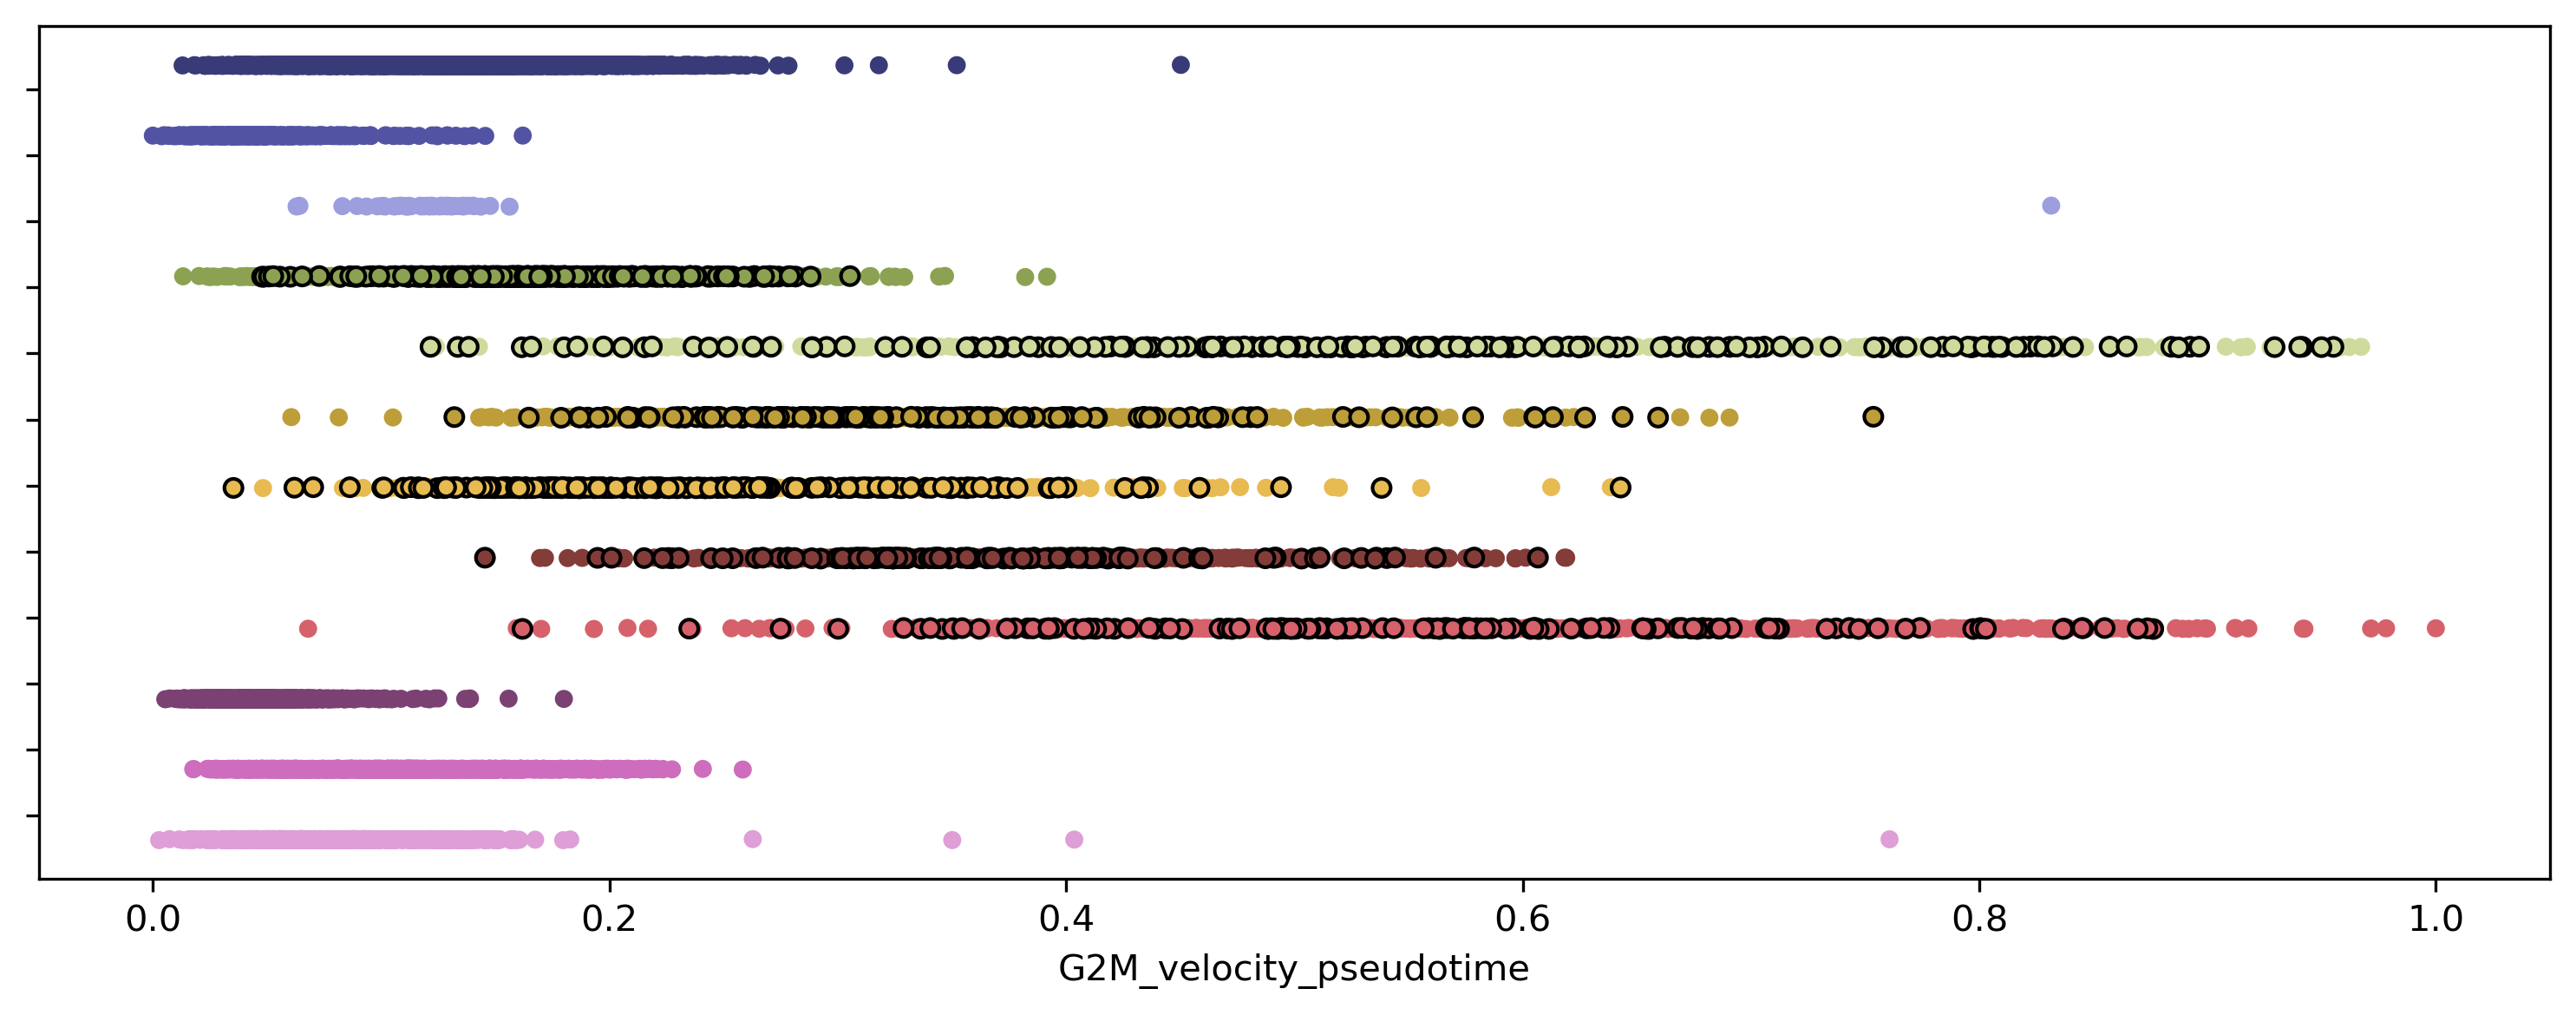

In [88]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 4

# Plot the base
sns.stripplot(
    data=cdata.obs,
    x='G2M_velocity_pseudotime',
    y='leiden_split',    # Use y instead of hue for alignment (y is categorical)
    hue='leiden_split',
    palette=cdata.uns['leiden_split_colors'],
    dodge=True,
    edgecolor='none',
    size=5,   # 's' is deprecated, use 'size'
    legend=False,
    linewidth=0,
)

# Plot highlighted cells WITH a black edge
sns.stripplot(
    data=cdata.obs[cdata.obs['high_ratio_cell']],
    x='G2M_velocity_pseudotime',
    y='leiden_split',
    hue='leiden_split',
    palette=cdata.uns['leiden_split_colors'],
    dodge=True,
    edgecolor='black',
    size=5,
    linewidth=1,
    legend=False,
)


plt.ylabel("")


plt.gca().margins(y=0.05)
plt.gca().tick_params(axis='y', labelleft=False)

plt.tight_layout()
plt.show()

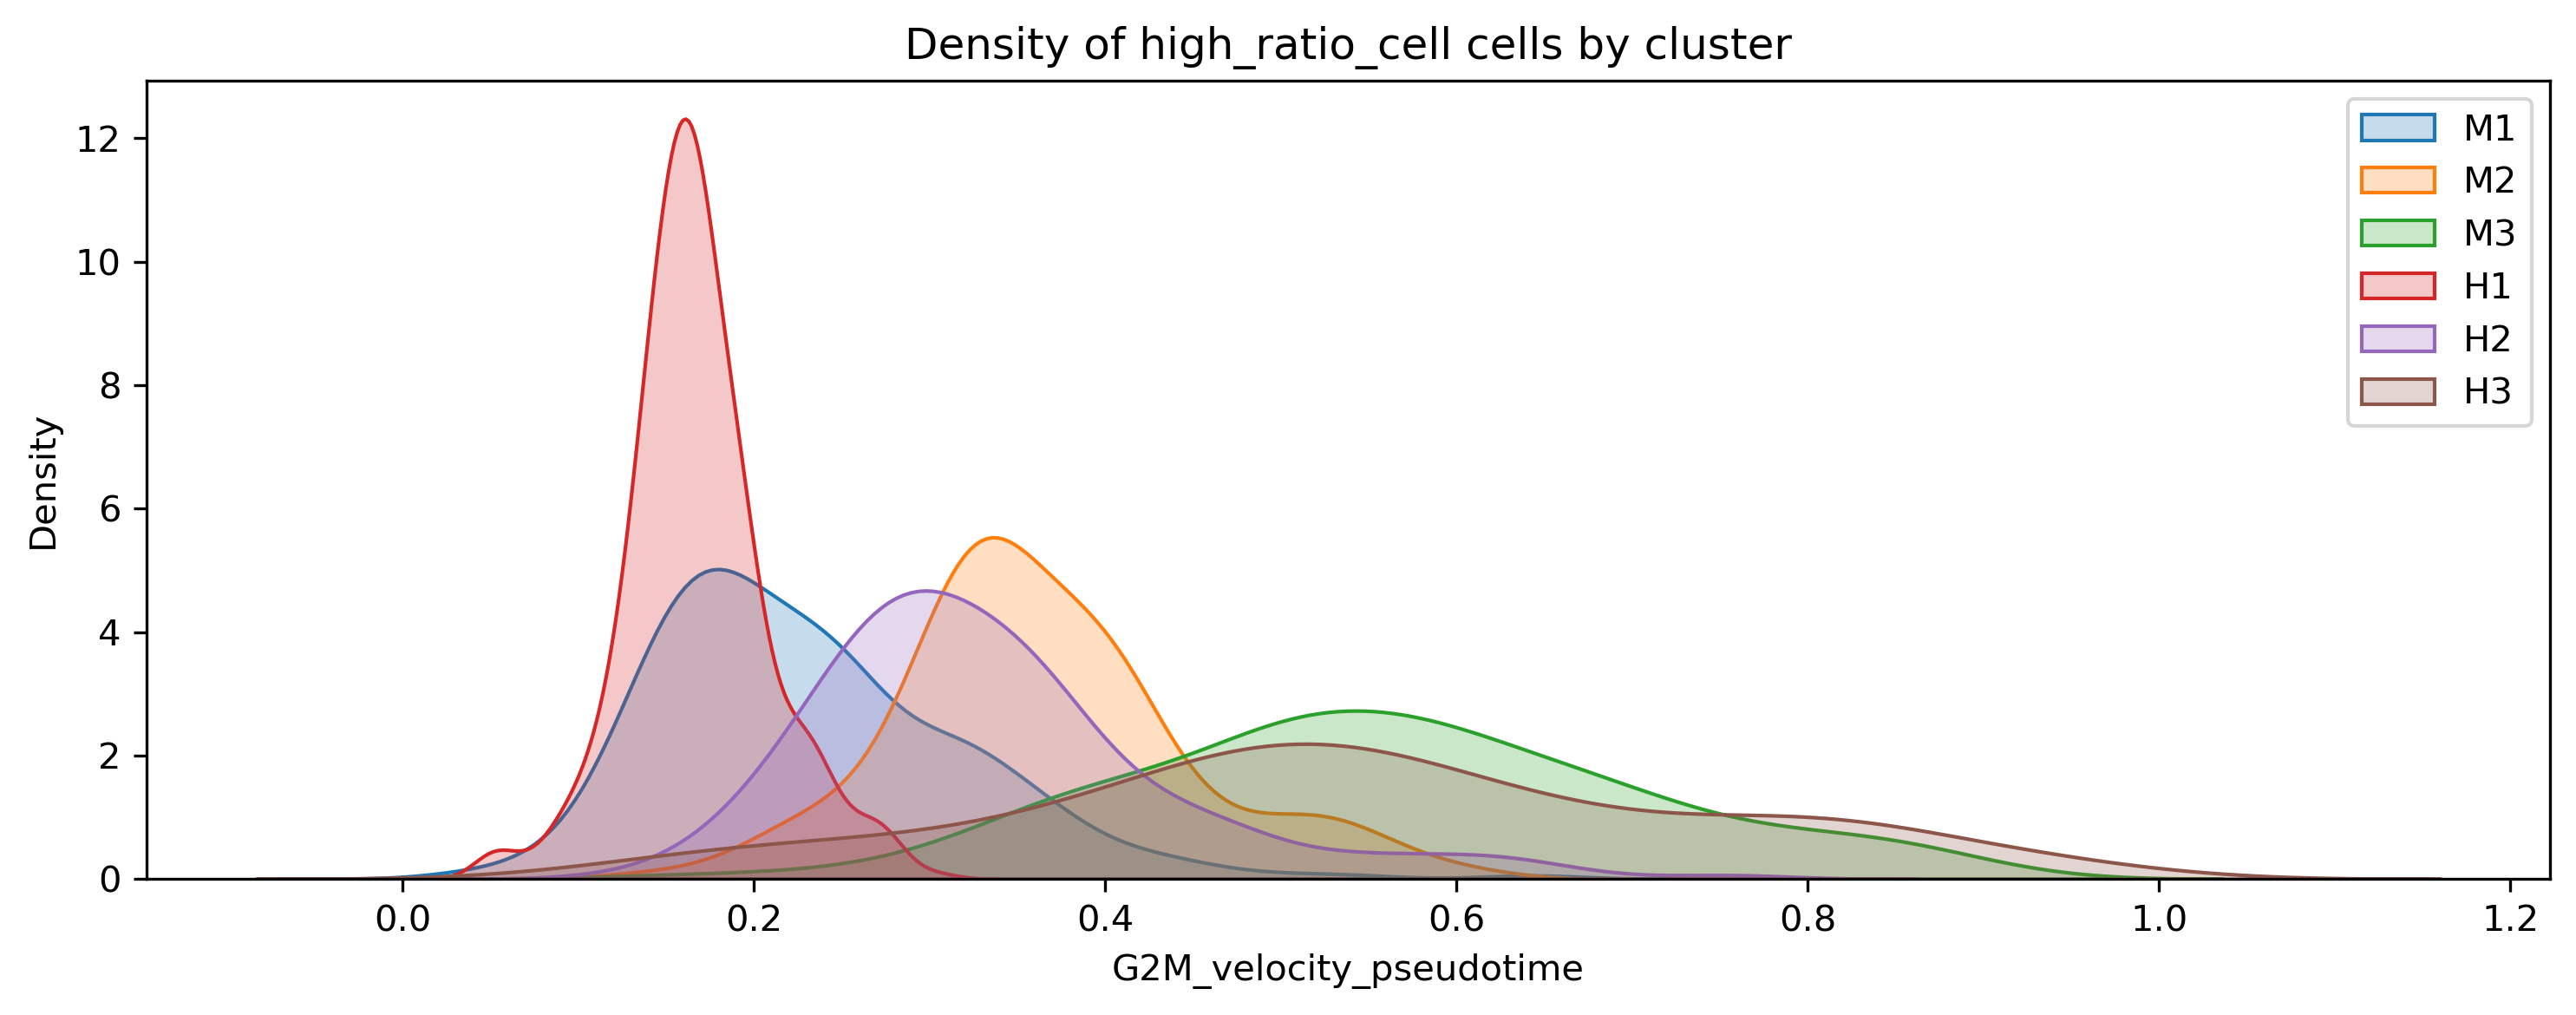

In [95]:
select_clusters = ['M1', 'M2', 'M3', 'H1', 'H2', 'H3']

subset = cdata.obs[
    (cdata.obs['high_ratio_cell']) &
    (cdata.obs['leiden_split'].isin(select_clusters))
]

plt.figure(figsize=(10, 4))

categories = cdata.obs['leiden_split'].cat.categories

for cluster in select_clusters:
    cluster_cells = subset[subset['leiden_split'] == cluster]
    # color_index = list(categories).index(cluster)
    # color = cdata.uns['leiden_split_colors'][color_index]
    sns.kdeplot(
        cluster_cells['G2M_velocity_pseudotime'],
        label=f'{cluster}',
        fill=True,
        # color=color,
    )

plt.xlabel('G2M_velocity_pseudotime')
plt.ylabel('Density')
plt.title('Density of high_ratio_cell cells by cluster')
plt.legend()
plt.tight_layout()
plt.show()

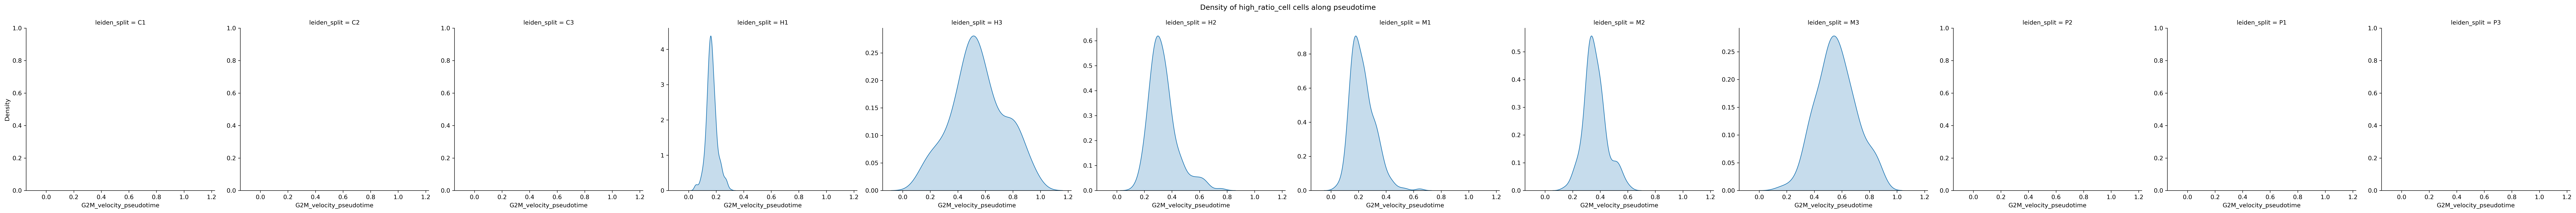

In [90]:
sns.displot(
    data=subset,
    x='G2M_velocity_pseudotime',
    col='leiden_split',
    kind='kde',
    facet_kws={'sharey': False},
    fill=True
)
plt.suptitle('Density of high_ratio_cell cells along pseudotime')
plt.tight_layout()
plt.show()


## Proportions

In [ ]:
# Count high ratio per pooled_condition X leiden_split
high_counts = (
    cdata.obs[cdata.obs['high_ratio_cell']]
    .groupby(['pooled_condition', 'leiden_split'])
    .size()
    .unstack(fill_value=0)
)

# Count ALL cells per pooled_condition
total_counts = cdata.obs.groupby('pooled_condition').size()

# Count high_ratio cells per pooled_condition (sum over leiden_split)
high_sum = high_counts.sum(axis=1)

# Non-high_ratio counts (for the gray segment)
gray_counts = total_counts - high_sum

# Add as new column
high_counts['Not_high_ratio'] = gray_counts


# Divide by total cells per pooled_condition to get proportions
prop_counts = high_counts.div(total_counts, axis=0)

leiden_order = list(cdata.obs['leiden_split'].cat.categories)
leiden_colors = [cdata.uns['leiden_split_colors'][i] for i in range(len(leiden_order))]
color_palette = leiden_colors + ['gray']

In [ ]:
prop_counts = prop_counts[[*leiden_order, 'Not_high_ratio']]  # Ensure column order

prop_counts.plot(
    kind='bar',
    stacked=True,
    color=color_palette,
    figsize=(10, 5)
)

plt.xlabel('Pooled Condition')
plt.ylabel('Proportion of cells')
plt.title('Composition of leiden_split and high_ratio per pooled_condition')
plt.legend(title='Cell Type', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()